# Data science for business project
This project is developed by 
- Drago Emanuele
- Lambrughi Achille

# Index


- [Introduction](#Introduction)<a href='#Introduction'></a><br>
- [Resources](#res)<a href='res'></a><br>
- [Configuration](#config)<a href='config'></a><br>
- [Library](#lib)<a href='lib'></a><br>
- [Function defined](#my_fun)<a href='my_fun'></a><br>

[**Dataset analysis**](#cap1)<a href='cap1'></a><br>
- [Dataset Import](#dt_import)<a href='dt_import'></a><br>
- [Outlier detection](#dec_outlier)<a href='dec_outlier'></a><br>
    - [DATA column](#data_cl)<a href='data_cl'></a><br>
    - [SETTOREECONOMICODETTAGLIO column](#set_ec_cl)<a href='linear_regression'></a><br>
    - [MODALITALAVORO column](#mod_work_cl)<a href='mod_work_cl'></a><br>
    
[**Building machine learning models**](#ml_model)<a href='ml_model'></a><br>
- [Feature encoding](#feature_encoding)<a href='feature_encoding'></a><br>
    - [Direct Encoding](#simp_encoding)<a href='simp_encoding'></a><br>
    - [Our Encoding](#elab_encoding)<a href='elab_encoding'></a><br>
- [Models Traning](#models_trainig)<a href='models_trainig'></a><br>


<a id='Introduction'></a>
## Introduction
The aim of this project is to illustrates various fases of a data science project. In the first fase we will import and analyze a dataset, then based on the analysis result we clean up the data removing outlier and null value.
Once the data is ready we will build a machine learning model able to respond to some question regarding the data.

<a id='res'></a>
## Resources
The datasets considered are available at the following link:
- https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-attivati/qbau-cyuc
- https://esploradati.censimentopopolazione.istat.it/databrowser/#/it/censtest/ITC4

other resources:
https://www.google.it/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiamPWll5T4AhUSG-wKHYxBBooQFnoECAcQAQ&url=https%3A%2F%2Fwww.istat.it%2Fstorage%2Fcodici-unita-amministrative%2FElenco-comuni-italiani.xls&usg=AOvVaw1grUzCb-YznlY1XTyzCUJE

in this file the column *Denominazione dell'Unità territoriale sovracomunale 
(valida a fini statistici)* has been renamed in *Provincia*



# Objective
Since the main dataset we have chosen it's a feature rich dataset representing all the new started working contracts, our goal is to predict the type of contract a person could be most probably hired

<a id='config'></a>
### Configuration
For this project will be used the module xgboost so for a correct compiling of the code is necessary to install it.

<a id='lib'></a>
### Library used
The following cell contain the main library used for the project, some library are imported right after used

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl, matplotlib.pyplot as plt
from pathlib import PurePath
from datetime import datetime, timedelta
import seaborn as sns
mpl.rcParams['figure.dpi'] = 150

<a id='my_fun'></a>
### Defining some function
Before proceding with the dataset we define the following function:
- `series_to_set`: this function take as input a column and a dataframe and returs a set containing the column value
- `mapping`: this function takes as input a series and a mapping dictionary,returns the series mapped to the dictionary

In [2]:
def series_to_set(column, source_df):
    SET = set()
    for elem in source_df[column]:
        SET.add(elem)
    return SET

def mapping(series, mapp): 
    series = series.apply(lambda x: mapp.get(x) if mapp.get(x) != None else x)
    return series

<a id='cap1'></a>
# Dataset analysis
In this section will be analyzed the content of the dataset. The choosen dataset contains the new work contract activated in Lombardy. The dataset contains the following column:
- DATA: date of the contract
- GENERE: sex of the person
- ETA: age of the person
- SETTOREECONOMICODETTAGLIO: category of work
- TITOLOSTUDIO: level of education of the person
- CONTRATTO: type of contract
- MODALITALAVORO: work mode
- PROVINCIAIMPRESA: province of the place of work
- ITALIANO: nationality of the person


<a id='dt_import'></a>
### Dataset import
 Here we import the dataset, parse the field `DATA` to datetime and take a first look at the column and their type.

In [3]:
source_df = pd.read_csv(PurePath('dataset', 'Rapporti_di_lavoro_attivati.csv'),parse_dates=['DATA'])

In [4]:
rap_lavoro_attivati = source_df.copy()

In [5]:
print([rap_lavoro_attivati.info()])
rap_lavoro_attivati.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     object        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  object        
 4   TITOLOSTUDIO               object        
 5   CONTRATTO                  object        
 6   MODALITALAVORO             object        
 7   PROVINCIAIMPRESA           object        
 8   ITALIANO                   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 657.8+ MB
[None]


,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,2020-09-05,F,60,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA
1,2019-12-07,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
2,2013-05-06,F,20,Fabbricazione di altre apparecchiature elettri...,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,2010-12-03,F,28,Alberghi,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE A TEMPO DETERMINATO,NON DEFINITO,BERGAMO,ITALIA
4,2021-06-04,F,49,Rifugi di montagna,LICENZA MEDIA,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA
5,2021-06-08,M,16,"Costruzione di strade, autostrade e piste aero...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018-04-03,F,56,Confezioni di abbigliamento sportivo o di altr...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
7,2011-06-10,M,20,Demolizione,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE,TEMPO PIENO,BERGAMO,ITALIA
8,2013-03-07,M,49,Demolizione,LICENZA MEDIA,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
9,2014-03-06,M,29,Ristorazione con somministrazione,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ERITREA


### Changing data type
As we can see almost all columns of the dataset have type object and contains strings, this  means that the machine learning model will be fed with catagorical data or a numerical rapresentation of it. Before proceding with the analysis we change the type from object to string.

Since categorical data are difficult to use for training a machine learning model, we already know that those value should be replaced with numerical values. So, during the analysis we will try to understand which values are more suitable for this task.

In [6]:
rap_lavoro_attivati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']]=rap_lavoro_attivati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']].astype('string')

### Searching wrong and null data
Now we will look inside the data checking null or possibly wrong value, after those data will be corrected or deleted.
First off we will find out how many null value there are in each column

In [7]:
print([rap_lavoro_attivati.isnull().sum()])

[DATA                              0
GENERE                            0
ETA                               0
SETTOREECONOMICODETTAGLIO      2888
TITOLOSTUDIO                    580
CONTRATTO                         0
MODALITALAVORO               440779
PROVINCIAIMPRESA                  0
ITALIANO                          0
dtype: int64]


From this first look is possible to see that a big part of value is missing from the column `MODALITALAVORO` of the dataset `Rapporti_di_lavoro_attivati` these value needs to be replaced while the other could be simply deleted because they represent a small part of the dataset.

But before proceding now will be checked the actual value of some columnn to see if there are some non plausible data.
Starting from the column `DATA`

<a id='dec_outlier'></a>
## Identifying outliers

<a id='data_cl'></a>
### column DATA

At first, we extract the year from the date, so that the column `DATA` easier to analyze

In [8]:
rap_lavoro_attivati['DATA'] = rap_lavoro_attivati['DATA'].apply(lambda x: x.year)

In [9]:
rap_lavoro_attivati = rap_lavoro_attivati[rap_lavoro_attivati['DATA'] < 2022]

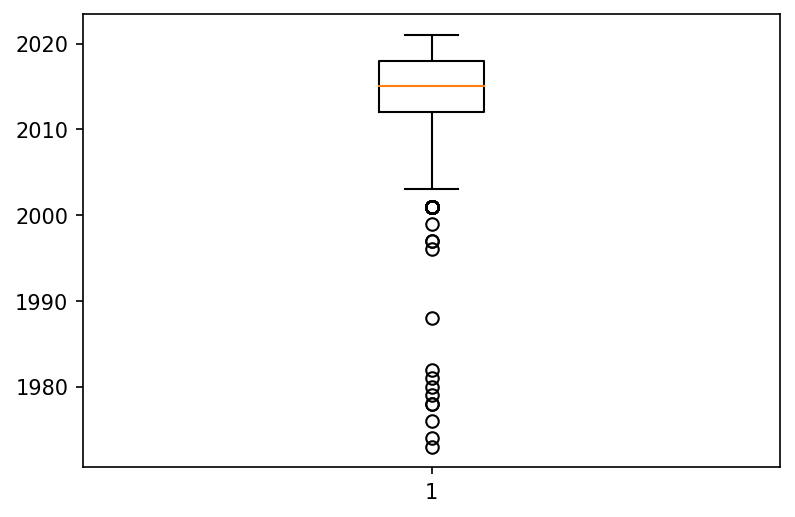

In [10]:
fig, ax = plt.subplots()
ax.boxplot(rap_lavoro_attivati['DATA'])
plt.show()

How can be seen from the above boxplot, we have many outliers in the years before 2000, so we should at least restrict the dataset to the last 20 years. Moreover, we will combine this dataset with other datasets that have values only for years 2018 and 2019. But this is not a problem, since those two years represents a quite recent job situation (differently from the early 2000s), while we don't analyze data from 2020 onwards because they are altered by the consequences of the COVID-19 pandemic.

In [11]:
rap_lavoro_attivati['DATA'].head()

0    2020
1    2019
2    2013
3    2010
4    2021
Name: DATA, dtype: int64


## Working on column `DATA`
In this section we will analyze in more detail the column `DATA` and adjust the data accordingly.
The first step is to group the column by year and count how many contract are activated per year

In [12]:
rap_lavoro_attivati = rap_lavoro_attivati[(rap_lavoro_attivati.DATA >= 2018) & (rap_lavoro_attivati.DATA < 2020)]
print(rap_lavoro_attivati.groupby(['DATA']).count())

      GENERE     ETA  SETTOREECONOMICODETTAGLIO  TITOLOSTUDIO  CONTRATTO  \
DATA                                                                       
2018  899082  899082                     898803        899082     899082   
2019  874079  874079                     873769        874079     874079   

      MODALITALAVORO  PROVINCIAIMPRESA  ITALIANO  
DATA                                              
2018          899082            899082    899082  
2019          874079            874079    874079  


With this we can see how many contract have been activated in the last few years in the Lombardy region.

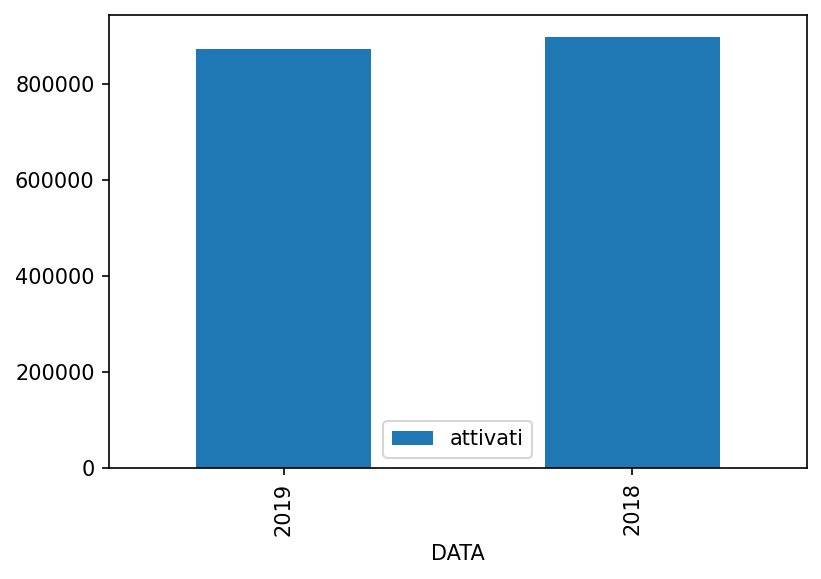

In [13]:
rap_lavoro_attivati.groupby(pd.Grouper(key='DATA'))['DATA'].count().plot(label="attivati", kind='bar')

plt.legend()
plt.show()

As we can see there isn't so much difference between the two years. The next graph show the percentrage difference between male and female 

(-1.1120274017317229,
 1.1262977938586096,
 -1.11073016988544,
 1.1005109604707353)

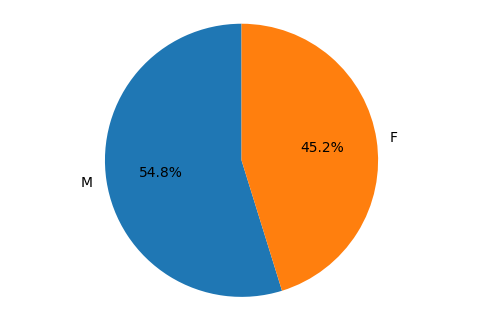

In [14]:
m_to_f_rationA = rap_lavoro_attivati.GENERE.value_counts()

xaxisA = m_to_f_rationA.index
valueA = m_to_f_rationA.values

fig1, axis = plt.subplots(1)
fig1.dpi = 100

#Attivati male to female Graph
axis.pie(valueA, labels=xaxisA, autopct='%1.1f%%', startangle=90)
axis.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


from these graphs we can say that probably there are more male than female in the popoulation, but this information should be verified plotting data from a dataset that involves the whole population, not only the newly hired.

In [15]:
rap_lavoro_attivati['DATA'].describe(datetime_is_numeric=True)

count    1.773161e+06
mean     2.018493e+03
std      4.999504e-01
min      2.018000e+03
25%      2.018000e+03
50%      2.018000e+03
75%      2.019000e+03
max      2.019000e+03
Name: DATA, dtype: float64

from this we can see that there is at least one date impossible so we restrain the data to only feasible one

In [16]:
rap_lavoro_attivati['DATA'].describe(datetime_is_numeric=True)

count    1.773161e+06
mean     2.018493e+03
std      4.999504e-01
min      2.018000e+03
25%      2.018000e+03
50%      2.018000e+03
75%      2.019000e+03
max      2.019000e+03
Name: DATA, dtype: float64

In [17]:
rap_lavoro_attivati['DATA'].max

<bound method NDFrame._add_numeric_operations.<locals>.max of 1          2019
6          2018
12         2019
23         2018
28         2019
           ... 
9579758    2018
9579764    2018
9579777    2018
9579779    2018
9579788    2019
Name: DATA, Length: 1773161, dtype: int64>

In [18]:
rap_lavoro_attivati.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
1,2019,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018,F,56,Confezioni di abbigliamento sportivo o di altr...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
12,2019,F,34,Istruzione di grado preparatorio: scuole dell'...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
23,2018,M,54,Allevamento di bovini e bufalini da carne,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO
28,2019,F,45,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA


The next plot represents the number of contracts `== LAVORO A TEMPO INDETERMINATO` in relation with the working time: full-time or part-time (and its derivations)

<AxesSubplot:xlabel='MODALITALAVORO'>

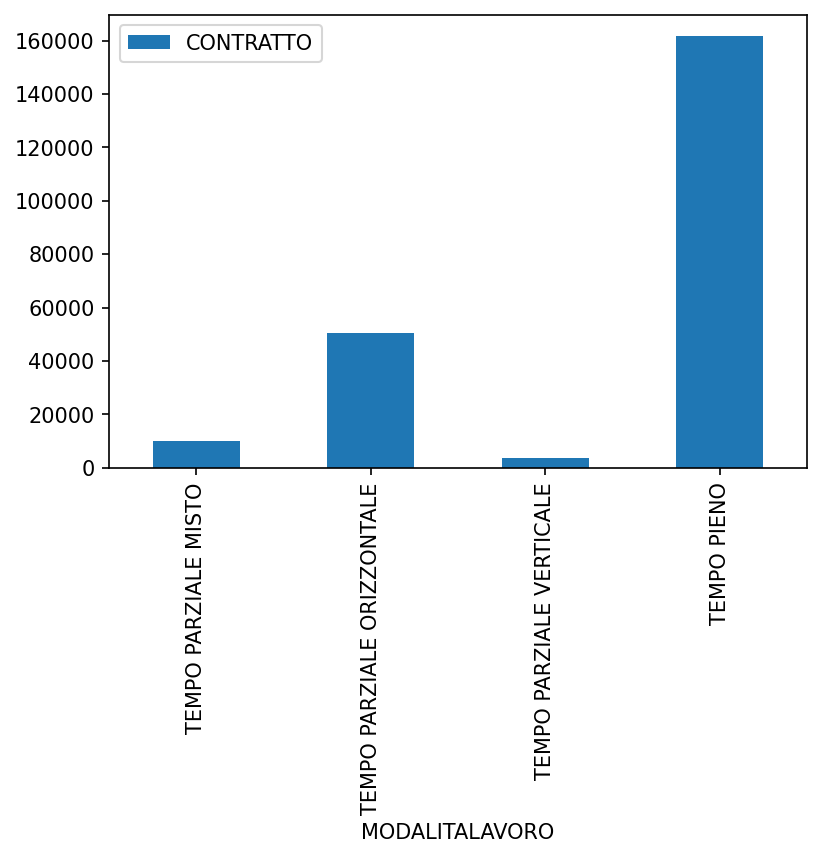

In [19]:
df = rap_lavoro_attivati[['CONTRATTO', 'MODALITALAVORO']]
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO']
df = df.groupby(['MODALITALAVORO']).count()
df.plot(kind='bar')

The result shows that the working hours and the contract type are highly correlated, hence the feature `MODALITALAVORO` must be exploited for our model.

Next, we will see if there is a correlation amongst province and contracts. 

Text(0, 0.5, 'Tempo indeterminato')

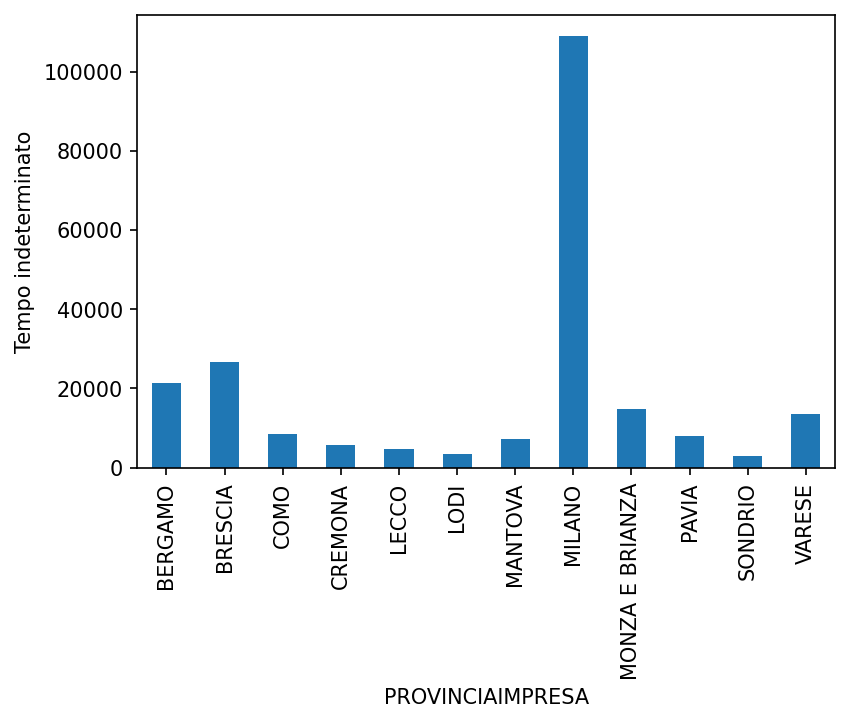

In [20]:
df = rap_lavoro_attivati[['CONTRATTO', 'PROVINCIAIMPRESA']]
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO']
df = df.groupby(['PROVINCIAIMPRESA']).count()
df.plot(kind='bar', legend=False)
plt.ylabel('Tempo indeterminato')

They seem to be correlated, BUT we should pay attention to what we have just plotted. Indeed, we have counted the **total** number of activated contracts in each province and this information could introduce errors in evaluation. This error bears in the fact that different provinces have different populations. To clarify, the population of Milan (province) sums to roughly 3.2 million people, while in province of Lodi live 230 thousands people. So, despite considering the total number of contract, we will consider the *percentage* over the total number of newly started contracts.  

Text(0, 0.5, '% Tempo determinato')

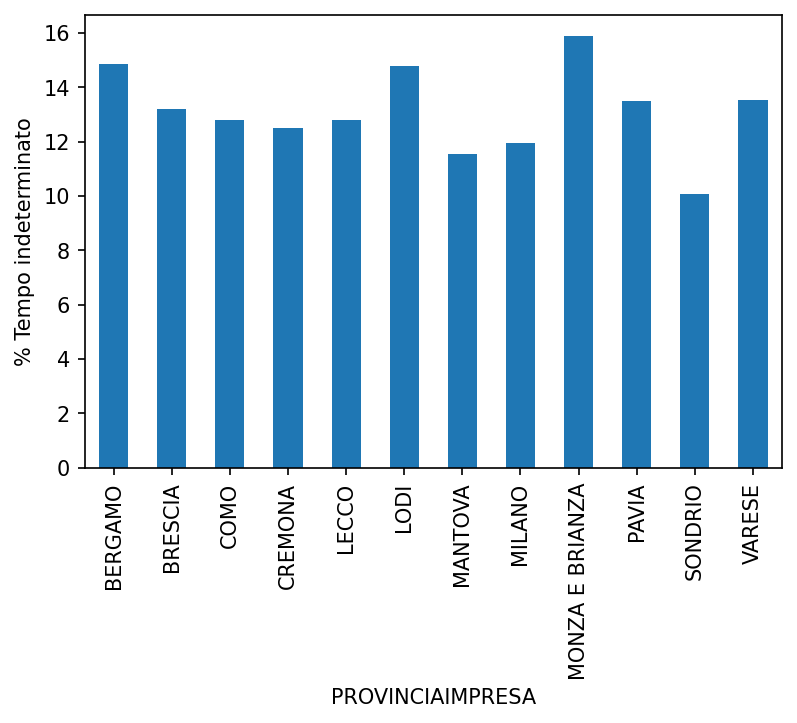

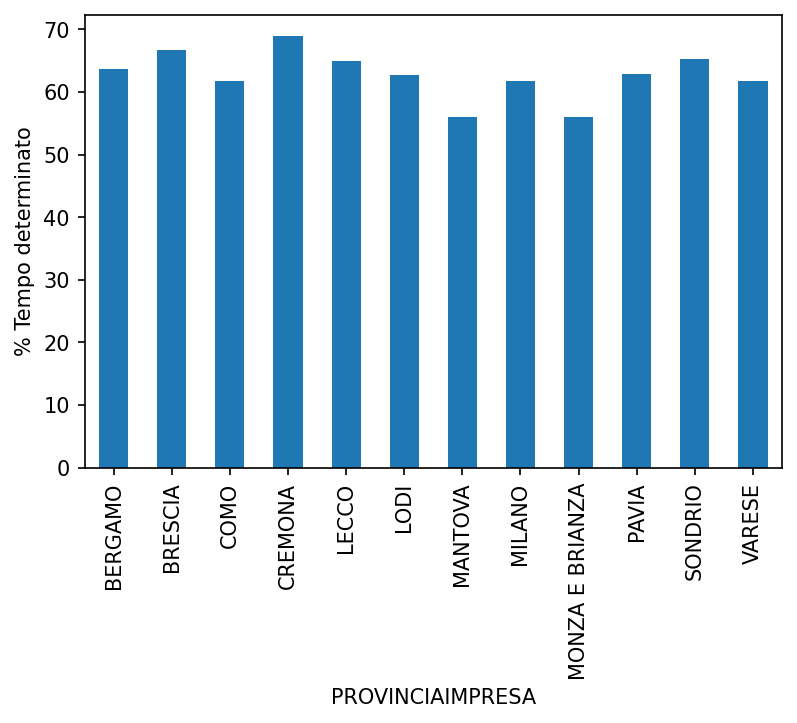

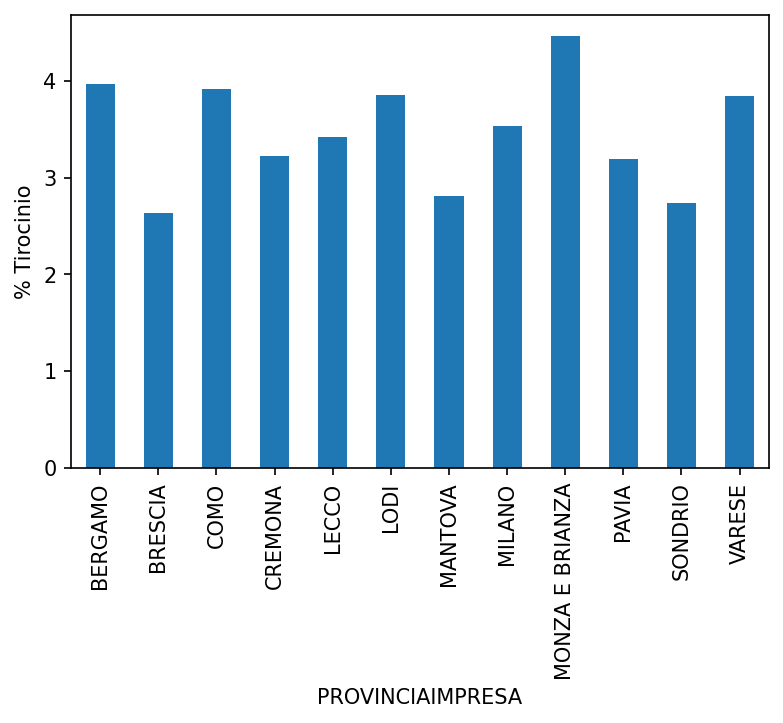

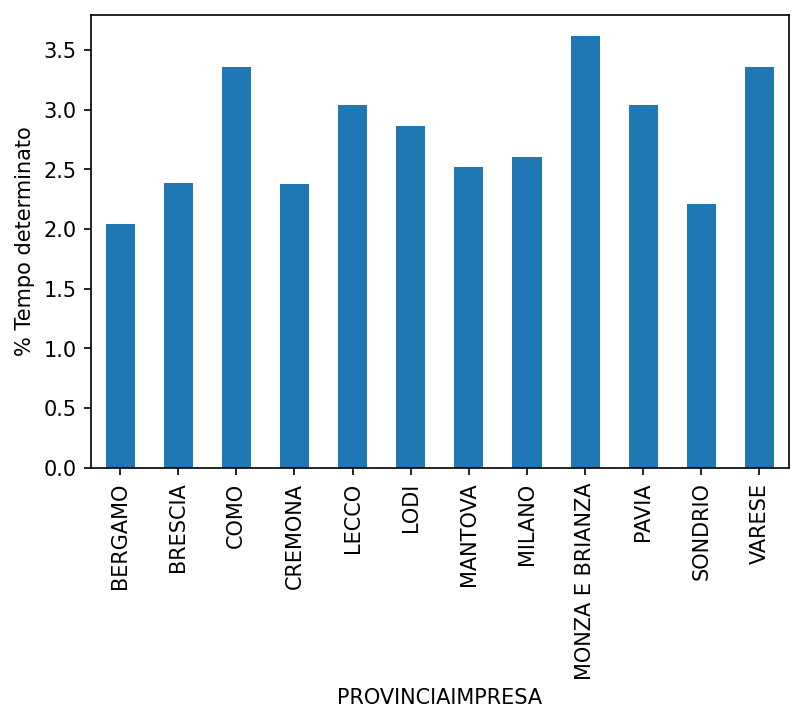

In [21]:
df = rap_lavoro_attivati[['CONTRATTO', 'PROVINCIAIMPRESA']]
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO']
df = df.groupby(['PROVINCIAIMPRESA']).count()
df.loc[:, 'CONTRATTO'] = 100*df["CONTRATTO"]/rap_lavoro_attivati.groupby(['PROVINCIAIMPRESA']).count()['CONTRATTO']
df.plot(kind='bar', legend=False)
plt.ylabel('% Tempo indeterminato')
################################################
df = rap_lavoro_attivati[['CONTRATTO', 'PROVINCIAIMPRESA']]
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO DETERMINATO']
df = df.groupby(['PROVINCIAIMPRESA']).count()
df.loc[:, 'CONTRATTO'] = 100*df["CONTRATTO"]/rap_lavoro_attivati.groupby(['PROVINCIAIMPRESA']).count()['CONTRATTO']
df.plot(kind='bar', legend=False)
plt.ylabel('% Tempo determinato')
################################################
df = rap_lavoro_attivati[['CONTRATTO', 'PROVINCIAIMPRESA']]
df = df[df['CONTRATTO'] == 'TIROCINIO']
df = df.groupby(['PROVINCIAIMPRESA']).count()
df.loc[:, 'CONTRATTO'] = 100*df["CONTRATTO"]/rap_lavoro_attivati.groupby(['PROVINCIAIMPRESA']).count()['CONTRATTO']
df.plot(kind='bar', legend=False)
plt.ylabel('% Tirocinio')
################################################
df = rap_lavoro_attivati[['CONTRATTO', 'PROVINCIAIMPRESA']]
df = df[df['CONTRATTO'] == 'LAVORO DOMESTICO']
df = df.groupby(['PROVINCIAIMPRESA']).count()
df.loc[:, 'CONTRATTO'] = 100*df["CONTRATTO"]/rap_lavoro_attivati.groupby(['PROVINCIAIMPRESA']).count()['CONTRATTO']
df.plot(kind='bar', legend=False)
plt.ylabel('% Tempo determinato')

From the plots we can tell that the type of contract and the province in which people work are related. 

We can note that for example `MONZA E BRIANZA` has the highest percetage in both open-ended contracts and internships, while it got the lowest percentage in fixed-term contracts. This could probably means that people in Monza e Brianza are more frequently hired in an internship and then their contract directly change to an open-ended contract. 

In [22]:
rap_lavoro_attivati.groupby(['PROVINCIAIMPRESA']).count()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,ITALIANO
PROVINCIAIMPRESA,,,,,,,,
BERGAMO,142970,142970,142970,142939,142970,142970,142970,142970
BRESCIA,200986,200986,200986,200930,200986,200986,200986,200986
COMO,66985,66985,66985,66957,66985,66985,66985,66985
CREMONA,44942,44942,44942,44933,44942,44942,44942,44942
LECCO,37175,37175,37175,37080,37175,37175,37175,37175
LODI,22654,22654,22654,22652,22654,22654,22654,22654
MANTOVA,63394,63394,63394,63380,63394,63394,63394,63394
MILANO,911881,911881,911881,911641,911881,911881,911881,911881
MONZA E BRIANZA,92657,92657,92657,92618,92657,92657,92657,92657


<a id='set_ec_cl'></a>
### column SETTOREECONOMICODETTAGLIO

In [23]:
settore_economico = series_to_set('SETTOREECONOMICODETTAGLIO', rap_lavoro_attivati)
len(settore_economico)

1183

Let's plot the data of `SETTOREECONOMICODETTAGLIO` and their 'weight' in the dataset.

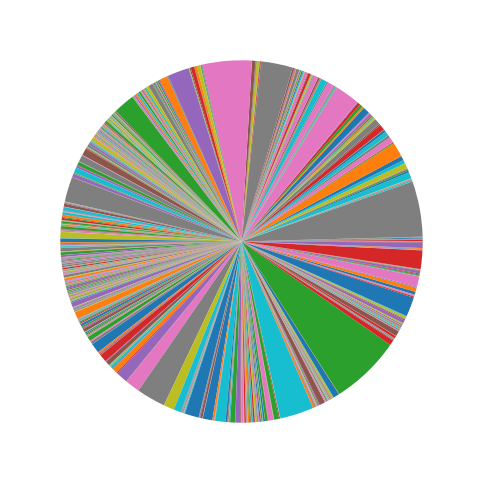

In [24]:
fig, axis = plt.subplots()

axis.pie(rap_lavoro_attivati.groupby(['SETTOREECONOMICODETTAGLIO']).count()['GENERE'])

plt.show()

It's a mess **!!!** This column, taken as it is, cannot be used for analysis; the amount of different data is frightening. 

There is a good news: it seems that the captions match with the Ateco Codes! Hence, we can map them into wider categories.

In [25]:
sett_eco_codes = pd.read_excel(PurePath('dataset', 'CodiceAteco.xlsx'))
sett_eco_codes.head()

,Lettera,Codice Ateco 2007,Descrizione
0,A,A,"AGRICOLTURA, SILVICOLTURA E PESCA"
1,A,01,COLTIVAZIONI AGRICOLE E PRODUZIONE DI PRODOTTI...
2,A,01.1,COLTIVAZIONE DI COLTURE AGRICOLE NON PERMANENTI
3,A,01.11,"Coltivazione di cereali (escluso il riso), leg..."
4,A,01.11.1,Coltivazione di cereali (escluso il riso)


In [26]:
sett_eco_codes['Descrizione'] = sett_eco_codes['Descrizione'].str.lower()
sett_eco_codes = sett_eco_codes[['Lettera', 'Descrizione']]
ateco = sett_eco_codes.set_index('Descrizione').to_dict().get('Lettera')

In [27]:
rap_lavoro_attivati["SETTOREECONOMICODETTAGLIO"] = rap_lavoro_attivati["SETTOREECONOMICODETTAGLIO"].str.lower()
rap_lavoro_attivati.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
1,2019,M,43,"gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018,F,56,confezioni di abbigliamento sportivo o di altr...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
12,2019,F,34,istruzione di grado preparatorio: scuole dell'...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
23,2018,M,54,allevamento di bovini e bufalini da carne,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO
28,2019,F,45,attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA


In [28]:
rap_lavoro_attivati["SETTOREECONOMICODETTAGLIO"] = rap_lavoro_attivati["SETTOREECONOMICODETTAGLIO"].map(ateco)
rap_lavoro_attivati.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
1,2019,M,43,NaN,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018,F,56,C,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
12,2019,F,34,P,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
23,2018,M,54,A,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO
28,2019,F,45,T,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA


In [29]:
rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].isna().sum()

35237

In [30]:
rap_lavoro_attivati = rap_lavoro_attivati[rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].notna()]

In [31]:
rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].isna().sum()

0

Now we can visualize the column after the mapping.

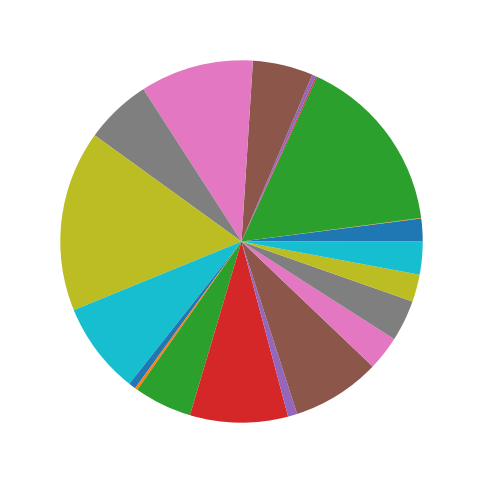

In [32]:
fig, axis = plt.subplots()

axis.pie(rap_lavoro_attivati.groupby(['SETTOREECONOMICODETTAGLIO']).count()['GENERE'])

plt.show()

So much better, now we don't have too much different values and so the column can be used for analisys.

Text(0, 0.5, '% Tempo indeterminato')

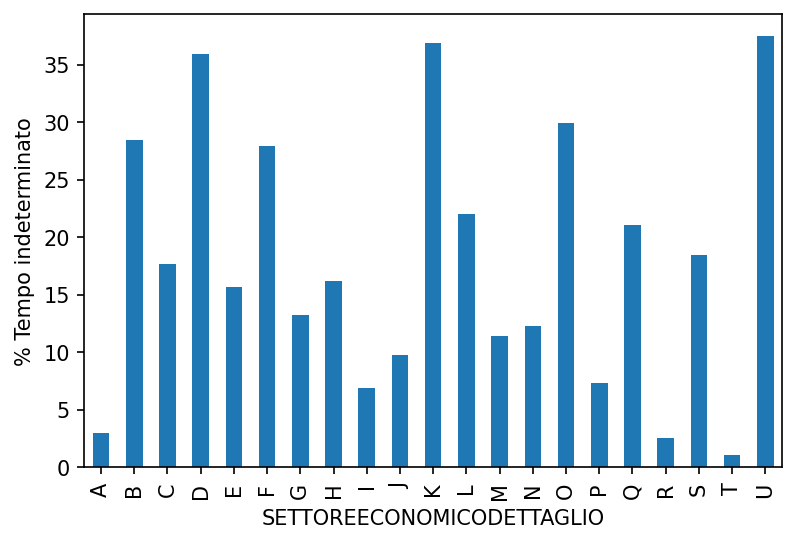

In [33]:
df = rap_lavoro_attivati[['CONTRATTO', 'SETTOREECONOMICODETTAGLIO']]
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO']
df = df.groupby(['SETTOREECONOMICODETTAGLIO']).count()
df.loc[:, 'CONTRATTO'] = 100*df["CONTRATTO"]/rap_lavoro_attivati.groupby(['SETTOREECONOMICODETTAGLIO']).count()['CONTRATTO']
df.plot(kind='bar', legend=False)
plt.ylabel('% Tempo indeterminato')

To correctly interpret the above bar plot, we should be aware of the meaning of the different character, so:
- A: AGRICOLTURA, SILVICOLTURA E PESCA;
- B: ESTRAZIONE DI MINERALI DA CAVE E MINIERE;
- C: ATTIVITÀ MANIFATTURIERE;
- D: FORNITURA DI ENERGIA ELETTRICA, GAS, VAPORE E ARIA CONDIZIONATA;
- E: FORNITURA DI ACQUA; RETI FOGNARIE, ATTIVITÀ DI GESTIONE DEI RIFIUTI E RISANAMENTO;
- F: COSTRUZIONI;
- G: COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZIONE DI AUTOVEICOLI E MOTOCICLI;
- H: TRASPORTO E MAGAZZINAGGIO;
- I: ATTIVITÀ DEI SERVIZI DI ALLOGGIO E DI RISTORAZIONE;
- J: SERVIZI DI INFORMAZIONE E COMUNICAZIONE;
- K: ATTIVITÀ FINANZIARIE E ASSICURATIVE;
- L: ATTIVITA' IMMOBILIARI;
- M: ATTIVITÀ PROFESSIONALI, SCIENTIFICHE E TECNICHE;
- N: NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPORTO ALLE IMPRESE;
- O: AMMINISTRAZIONE PUBBLICA E DIFESA; ASSICURAZIONE SOCIALE OBBLIGATORIA;
- P: ISTRUZIONE;
- Q: SANITA' E ASSISTENZA SOCIALE;
- R: ATTIVITÀ ARTISTICHE, SPORTIVE, DI INTRATTENIMENTO E DIVERTIMENTO;
- S: ALTRE ATTIVITÀ DI SERVIZI;
- T: ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI DI LAVORO PER PERSONALE DOMESTICO; PRODUZIONE DI BENI E SERVIZI INDIFFERENZIATI PER USO PROPRIO DA PARTE DI FAMIGLIE E CONVIVENZE;
- U: ORGANIZZAZIONI ED ORGANISMI EXTRATERRITORIALI;

Since the `SETTOREECONOMICODETTAGLIO` column has more than a thousand unique values belonging to it, it cannot be easily exploited to analyze data (e.g. dividing them into categories). Furthermore, the majority of the value belongs to some feature, considering these facts we will keep 50 of the most common category.

In [34]:
rap_lavoro_attivati['CONTRATTO'].value_counts()

LAVORO A TEMPO DETERMINATO                           1083539
LAVORO A TEMPO INDETERMINATO                          221196
LAVORO INTERMITTENTE                                  112446
LAVORO AUTONOMO NELLO SPETTACOLO                       63546
TIROCINIO                                              60532
LAVORO A TEMPO DETERMINATO  PER SOSTITUZIONE           52591
APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...      48871
LAVORO DOMESTICO                                       47329
COLLABORAZIONE COORDINATA E CONTINUATIVA               41555
APPRENDISTATO PER LA QUALIFICA E PER IL DIPLOM...       2220
LAVORO O ATTIVITÀ SOCIALMENTE UTILE (LSU - ASU)         1448
LAVORO A DOMICILIO                                       853
CONTRATTO DI AGENZIA                                     819
CONTRATTI DI BORSA LAVORO E ALTRE WORK EXPERIE...        718
APPRENDISTATO DI ALTA FORMAZIONE E RICERCA               133
CONTRATTO DI FORMAZIONE LAVORO (SOLO PUBBLICA ...         73
LAVORO CONGIUNTO IN AGRI

As we can see there are category with just a few entries, because these have a low impact on the dataset we can delete them with the following function that group the data by `CONTRATTO`, create a group of indexes containing only the elements that satisfy a condition, in this case the value must be greater than 2000, and then we keep only the value that are inside those indexes.

In [35]:
#delete low number contracts
byContract = rap_lavoro_attivati.groupby('CONTRATTO').aggregate(np.count_nonzero)
tags = byContract[byContract.GENERE >= 2000].index
rap_lavoro_attivati = rap_lavoro_attivati[rap_lavoro_attivati['CONTRATTO'].isin(tags)]

<a id='mod_work_cl'></a>
### Column MODALITALAVORO

In the `rap_lavoro_attivati` there are a lot of null values for the column `MODALITALAVORO`, removing the rows would reduce the set of data we are analysing. Hence, we'd rather prefer to fill those null values with a suitable values. 

The value `NON DEFINITO` can be used to fill the na, since that won't introduce much bias, differently from the other available values. 

In [36]:
def clean(df):
    df['MODALITALAVORO'] = df['MODALITALAVORO'].fillna('NON DEFINITO')
    df.dropna(axis = 0, inplace = True)
    

clean(rap_lavoro_attivati)
rap_lavoro_attivati.isnull().sum()

DATA                         0
GENERE                       0
ETA                          0
SETTOREECONOMICODETTAGLIO    0
TITOLOSTUDIO                 0
CONTRATTO                    0
MODALITALAVORO               0
PROVINCIAIMPRESA             0
ITALIANO                     0
dtype: int64

### Column GENERE
Now we will try to understand if the gender and the contract type are related

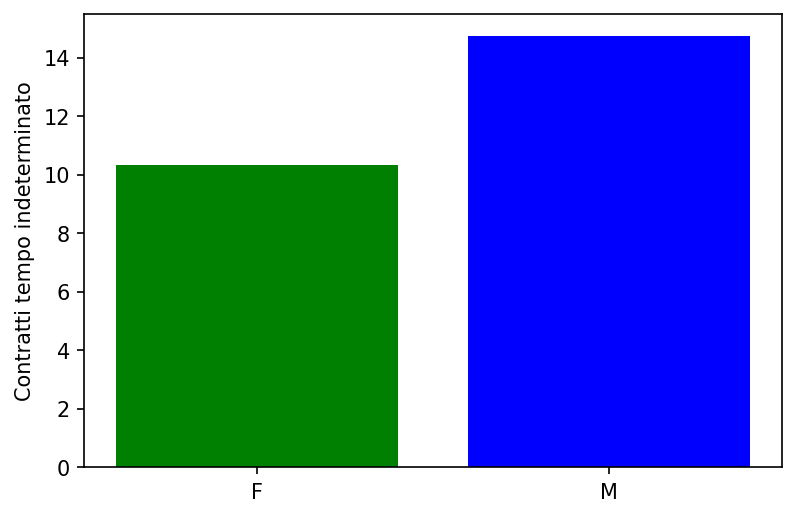

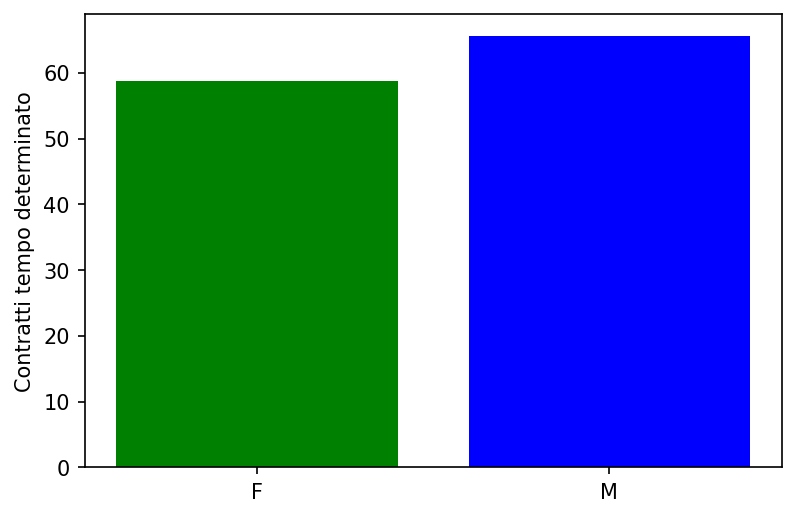

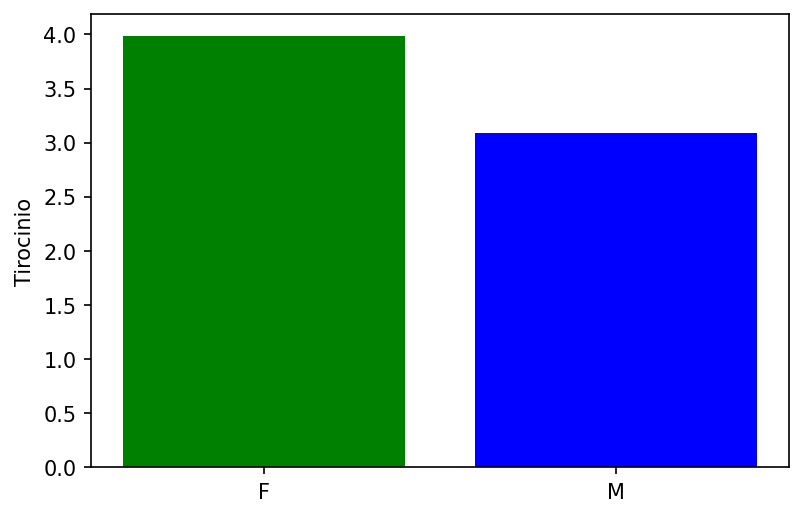

In [37]:
gender_df = rap_lavoro_attivati[['GENERE', "CONTRATTO"]]
gender_df = gender_df[gender_df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO']
group_gender = gender_df.groupby(['GENERE']).count()

group_gender.loc[:, 'CONTRATTO'] = 100*group_gender["CONTRATTO"]/rap_lavoro_attivati.groupby(['GENERE']).count()['CONTRATTO']

fig, ax = plt.subplots()
colors = ['green', 'blue']
ax.bar(group_gender.index, group_gender['CONTRATTO'], color=colors)
ax.set_ylabel('Contratti tempo indeterminato')
plt.show()
################
gender_df = rap_lavoro_attivati[['GENERE', "CONTRATTO"]]
gender_df = gender_df[gender_df['CONTRATTO'] == 'LAVORO A TEMPO DETERMINATO']
group_gender = gender_df.groupby(['GENERE']).count()
group_gender.loc[:, 'CONTRATTO'] = 100*group_gender["CONTRATTO"]/rap_lavoro_attivati.groupby(['GENERE']).count()['CONTRATTO']

fig, ax = plt.subplots()
colors = ['green', 'blue']
ax.bar(group_gender.index, group_gender['CONTRATTO'], color=colors)
ax.set_ylabel('Contratti tempo determinato')
plt.show()
#################
gender_df = rap_lavoro_attivati[['GENERE', "CONTRATTO"]]
gender_df = gender_df[gender_df['CONTRATTO'] == 'TIROCINIO']
group_gender = gender_df.groupby(['GENERE']).count()
group_gender.loc[:, 'CONTRATTO'] = 100*group_gender["CONTRATTO"]/rap_lavoro_attivati.groupby(['GENERE']).count()['CONTRATTO']

fig, ax = plt.subplots()
colors = ['green', 'blue']
ax.bar(group_gender.index, group_gender['CONTRATTO'], color=colors)
ax.set_ylabel('Tirocinio')
plt.show()

They seem to be highly correlated. Sadly we notice that over all the started contracts, women are hired in an open-ended contract in $\sim{10}\%$ of the number of contracts, while men get a $\sim14\%$ over the total number. This is a *huge* inequality. The same (but opposite) happens for internships, indeed women are on $\sim 4\%$, while men are at $\sim 3\%$. 

In [38]:
set(rap_lavoro_attivati['CONTRATTO'])

{'APPRENDISTATO PER LA QUALIFICA E PER IL DIPLOMA PROFESSIONALE, IL DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE E IL CERTIFICATO DI SPECIALIZZAZIONE TECNICA SUPERIORE',
 'APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO DI MESTIERE',
 'COLLABORAZIONE COORDINATA E CONTINUATIVA',
 'LAVORO A TEMPO DETERMINATO',
 'LAVORO A TEMPO DETERMINATO  PER SOSTITUZIONE',
 'LAVORO A TEMPO INDETERMINATO',
 'LAVORO AUTONOMO NELLO SPETTACOLO',
 'LAVORO DOMESTICO',
 'LAVORO INTERMITTENTE',
 'TIROCINIO'}

### Dividing by age group
For a better reading of the data we create a new column for the age group

In [39]:
bins = np.arange(14, 68, 3).tolist()
bins

[14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65]

In [40]:
bins = np.arange(14, 68, 3).tolist()
rap_lavoro_attivati['agerange'] = pd.cut(rap_lavoro_attivati['ETA'], bins)
rap_lavoro_attivati

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,agerange
6,2018,F,56,C,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,"(53, 56]"
12,2019,F,34,P,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,"(32, 35]"
23,2018,M,54,A,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO,"(53, 56]"
28,2019,F,45,T,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,"(44, 47]"
29,2019,F,28,G,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,"(26, 29]"
...,...,...,...,...,...,...,...,...,...,...
9579758,2018,M,29,I,NESSUN TITOLO DI STUDIO,LAVORO INTERMITTENTE,NON DEFINITO,MONZA E BRIANZA,ITALIA,"(26, 29]"
9579764,2018,F,41,I,TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCO...,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,ITALIA,"(38, 41]"
9579777,2018,F,35,I,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,ITALIA,"(32, 35]"
9579779,2018,M,35,F,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MONZA E BRIANZA,ITALIA,"(32, 35]"


In [41]:
rap_lavoro_attivati.dropna(axis = 0, inplace = True)

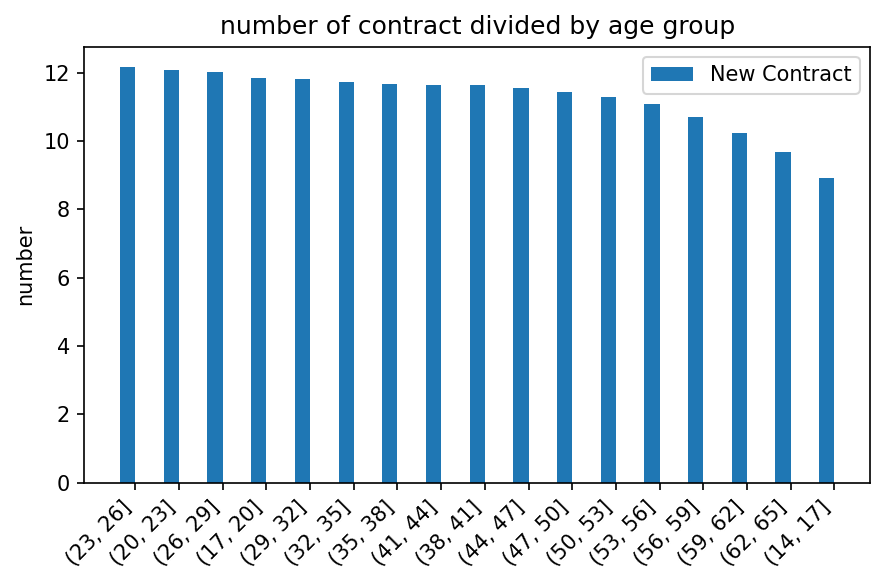

In [42]:
testAge = rap_lavoro_attivati.agerange.value_counts()

labels = testAge.index
newContract = np.log(testAge.values)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, newContract, width, label='New Contract')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('number')
ax.set_title('number of contract divided by age group')
ax.set_xticks(x)
ax.set_xticklabels(labels=labels,rotation=45,
    horizontalalignment='right');
ax.legend()



fig.tight_layout()

plt.show()

## Introducing another dataset
This dataset contain the level of education for age referred to the region lombardy from the year 2018 to 2020.The educational levels  are encoded in the following way:
- NED = nessun titolo di studio
- IL =  analfabeti
- LBNA = analfabeti privi di titolo di studio
- PSE = licenza di scuola elementare
- LSE = licenza media o avviamento professionale (conseguito non oltre l'anno 1965)/ Diploma di istruzione secondaria di I grado
- USE_IF = Diploma di istruzione secondaria di II grado o di qualifica professionale (corso di 3-4 anni) compresi IFTS
- BL = Diploma tecnico superiore ITS o titolo di studio terziario di primo livello
- ML_RDD = titolo di studio terziario di secondo livello e dottorato di ricerca
- ML = Titolo di studio terziario di secondo livello
- RDD = Dottorato di ricerca/diploma accademico di formazione alla ricerca
- ALL = totale

In [43]:
grado_istruzione_age  = pd.read_csv(PurePath('dataset', 'Grado_istruzione_per_età_Lombardia_IT1,DF_DCSS_ISTR_LAV_PEN_2_REG.csv'),low_memory=False)
grado_istruzione_age.head()

,DATAFLOW,FREQ,REF_AREA,INDICATOR,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE,OBS_STATUS,NOTE_DS,NOTE_REF_AREA,NOTE_INDICATOR,NOTE_GENDER,NOTE_AGE_NOCLASS,NOTE_CITIZENSHIP,NOTE_EDU_ATTAIN,NOTE_CUR_ACT_STAT,NOTE_LOC_DEST,NOTE_REAS_COMMUTING
0,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2018,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
1,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2019,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
2,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2020,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
3,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,BL,2018,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BL_N1,99_N1,NaN,NaN
4,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,BL,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BL_N1,99_N1,NaN,NaN


In [44]:
print([grado_istruzione_age.isnull().sum()])

[DATAFLOW                    0
FREQ                        0
REF_AREA                    0
INDICATOR                   0
GENDER                      0
AGE_NOCLASS                 0
EDU_ATTAIN                  0
TIME_PERIOD                 0
OBS_VALUE                   0
OBS_STATUS             508956
NOTE_DS                508956
NOTE_REF_AREA          504601
NOTE_INDICATOR         508956
NOTE_GENDER            508956
NOTE_AGE_NOCLASS       508956
NOTE_CITIZENSHIP       508956
NOTE_EDU_ATTAIN        185896
NOTE_CUR_ACT_STAT           0
NOTE_LOC_DEST          508956
NOTE_REAS_COMMUTING    508956
dtype: int64]


there are some column with null value that can be deleted

In [45]:
grado_istruzione_age = grado_istruzione_age[['REF_AREA', 'GENDER', 'AGE_NOCLASS', 'EDU_ATTAIN', 'TIME_PERIOD', 'OBS_VALUE']]

In [46]:
grado_istruzione_age ['AGE_NOCLASS'].value_counts()

Y_GE9     145979
Y25-49     92357
Y50-64     91652
Y_GE65     90061
Y9-24      88907
Name: AGE_NOCLASS, dtype: int64

those value represet age range in specific:
- Y_GE9: all people with age greater than 9, in this case all the people in the dataset
- Y25-49: people with an age between 25 and 49
- Y50-64: people with an age between 50 and 64
- Y_GE65: people with more than 65 years
- Y9-24: people with an age between 9 and 24

In the following part we will add a column with the saem age range of the dataset *Grado_istruzione_per_età_Lombardia*

Since in the dataset *rapporti di lavoro* the minimum age is 16 while in *Grado_istruzione_per_età_Lombardia* is 9 we will delete all the illiterate and the people with only elementary school license with the age between 9 and 24  from the dataset, we have chosen to do so because the majority of people in that age range with only elementary school license are the one under 16 year

In [47]:
grado_istruzione_age = grado_istruzione_age [~((grado_istruzione_age ['EDU_ATTAIN']== 'IL')|(grado_istruzione_age ['EDU_ATTAIN']== 'LBNA')|((grado_istruzione_age ['EDU_ATTAIN']== 'PSE')&(grado_istruzione_age ['AGE_NOCLASS']== 'Y9_24')))]
grado_istruzione_age

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
0,012001,F,Y_GE65,ALL,2018,54
1,012001,F,Y_GE65,ALL,2019,59
2,012001,F,Y_GE65,ALL,2020,63
3,012001,F,Y_GE65,BL,2018,3
4,012001,F,Y_GE65,BL,2019,3
...,...,...,...,...,...,...
508951,ITC4B,T,Y9-24,PSE,2019,12282
508952,ITC4B,T,Y9-24,PSE,2020,12409
508953,ITC4B,T,Y9-24,USE_IF,2018,16491
508954,ITC4B,T,Y9-24,USE_IF,2019,16647


In [48]:
print(rap_lavoro_attivati['TITOLOSTUDIO'].head())
grado_istruzione_age['EDU_ATTAIN'].head()

6                                         LICENZA MEDIA
12                 LAUREA - Vecchio o nuovo ordinamento
23                              NESSUN TITOLO DI STUDIO
28                              NESSUN TITOLO DI STUDIO
29    DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...
Name: TITOLOSTUDIO, dtype: string


0    ALL
1    ALL
2    ALL
3     BL
4     BL
Name: EDU_ATTAIN, dtype: object

In [49]:
print(series_to_set('TITOLOSTUDIO', rap_lavoro_attivati))
print(series_to_set('EDU_ATTAIN', grado_istruzione_age))

{'TITOLO DI STUDIO POST-LAUREA', 'DIPLOMA DI SPECIALIZZAZIONE', 'LAUREA - Vecchio o nuovo ordinamento', 'TITOLO DI DOTTORE DI RICERCA', 'MASTER UNIVERSITARIO DI PRIMO LIVELLO', "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()", 'NESSUN TITOLO DI STUDIO', 'LICENZA MEDIA', 'LICENZA ELEMENTARE', 'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO', "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA", 'DIPLOMA UNIVERSITARIO'}
{'LSE', 'BL', 'PSE', 'RDD', 'ALL', 'ML_RDD', 'NED', 'USE_IF', 'ML'}


In [50]:
grado_istruzione_age.loc[(grado_istruzione_age.EDU_ATTAIN.isin(['ML_RDD'])) & ~(grado_istruzione_age.AGE_NOCLASS == 'Y_GE9')]

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
9,012001,F,Y_GE65,ML_RDD,2018,4
10,012001,F,Y_GE65,ML_RDD,2019,4
11,012001,F,Y_GE65,ML_RDD,2020,3
58,012001,F,Y25-49,ML_RDD,2018,16
59,012001,F,Y25-49,ML_RDD,2019,15
...,...,...,...,...,...,...
508924,ITC4B,T,Y50-64,ML_RDD,2019,7841
508925,ITC4B,T,Y50-64,ML_RDD,2020,8141
508944,ITC4B,T,Y9-24,ML_RDD,2018,302
508945,ITC4B,T,Y9-24,ML_RDD,2019,186


In [51]:
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age['TIME_PERIOD'] != 2020]
grado_istruzione_age = grado_istruzione_age[~grado_istruzione_age.EDU_ATTAIN.isin(['ALL', 'ML', 'RDD'])]
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.AGE_NOCLASS != 'Y_GE9']
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.GENDER != 'T']
grado_istruzione_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
3,012001,F,Y_GE65,BL,2018,3
4,012001,F,Y_GE65,BL,2019,3
6,012001,F,Y_GE65,LSE,2018,11
7,012001,F,Y_GE65,LSE,2019,19
9,012001,F,Y_GE65,ML_RDD,2018,4


Unfortunately the educational levels of the two datasets don't match easily, but we can try to generalize a bit and to map the different values to the same set. In this way we can then unify the two dataset, or at least analyze the first dataset exploiting the second. 

In [52]:
edu_map = {
    'IL': 'NESSUN TITOLO DI STUDIO',
    'NED': 'NESSUN TITOLO DI STUDIO',
    'LBNA': 'NESSUN TITOLO DI STUDIO',
    'PSE': 'LICENZA ELEMENTARE',
    'LSE': 'LICENZA MEDIA',
    'USE_IF': 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()": 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA": 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    'BL': 'LAUREA',
    'ML_RDD': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'LAUREA - Vecchio o nuovo ordinamento': 'LAUREA',
    'DIPLOMA DI SPECIALIZZAZIONE': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'DIPLOMA UNIVERSITARIO': 'LAUREA',
    'TITOLO DI STUDIO POST-LAUREA': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'TITOLO DI DOTTORE DI RICERCA': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO'
}


In [53]:
def mapping(series, mapp): 
    series = series.apply(lambda x: mapp.get(x) if mapp.get(x) != None else x)
    return series

rap_lavoro_attivati['TITOLOSTUDIO'] = mapping(rap_lavoro_attivati['TITOLOSTUDIO'], edu_map)

grado_istruzione_age['EDU_ATTAIN'] = mapping(grado_istruzione_age['EDU_ATTAIN'], edu_map)

grado_istruzione_age['EDU_ATTAIN']


3                                                    LAUREA
4                                                    LAUREA
6                                             LICENZA MEDIA
7                                             LICENZA MEDIA
9         TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO ...
                                ...                        
508831                              NESSUN TITOLO DI STUDIO
508833                                   LICENZA ELEMENTARE
508834                                   LICENZA ELEMENTARE
508836           DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
508837           DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
Name: EDU_ATTAIN, Length: 135309, dtype: object

In [54]:
city_codes = pd.read_excel(PurePath('dataset', 'Elenco-comuni-italiani.xls'))
city_codes = city_codes[['Codice Comune formato alfanumerico', 
                        'Denominazione in italiano',
                        'Denominazione Regione',
                        'Provincia',
                        'Codice NUTS3 2021',
                        'Codice NUTS2 2021 (3) '
                        ]]
city_codes = city_codes[city_codes['Denominazione Regione'] == 'Lombardia']
city_codes = city_codes.set_index('Codice Comune formato alfanumerico')
city_codes.loc[1] = ['','','Milano','ITC45','']   #The code in the dataset does not match with the code of Milano, 
                                                  #manually added
city_codes.head()

,Denominazione in italiano,Denominazione Regione,Provincia,Codice NUTS3 2021,Codice NUTS2 2021 (3)
Codice Comune formato alfanumerico,,,,,
12001,Agra,Lombardia,Varese,ITC41,ITC4
12002,Albizzate,Lombardia,Varese,ITC41,ITC4
12003,Angera,Lombardia,Varese,ITC41,ITC4
12004,Arcisate,Lombardia,Varese,ITC41,ITC4
12005,Arsago Seprio,Lombardia,Varese,ITC41,ITC4


In [55]:
def get_provincia_by_code(code):
    try:
        return city_codes[city_codes['Codice NUTS3 2021'] == code]['Provincia'].iloc[0]
    except: 
        if code == 'IT108':
            return 'MONZA E BRIANZA'
                    

In [56]:
area_codes = set(city_codes['Codice NUTS3 2021'])
area_codes.add('IT108')
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.REF_AREA.isin(area_codes)]

In [57]:
grado_istruzione_age['REF_AREA'] = grado_istruzione_age['REF_AREA'].apply(lambda x: get_provincia_by_code(x)) 
grado_istruzione_age

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
504396,MONZA E BRIANZA,F,Y_GE65,LAUREA,2018,610
504397,MONZA E BRIANZA,F,Y_GE65,LAUREA,2019,543
504399,MONZA E BRIANZA,F,Y_GE65,LICENZA MEDIA,2018,24744
504400,MONZA E BRIANZA,F,Y_GE65,LICENZA MEDIA,2019,25871
504402,MONZA E BRIANZA,F,Y_GE65,TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO ...,2018,3595
...,...,...,...,...,...,...
508831,Mantova,M,Y9-24,NESSUN TITOLO DI STUDIO,2019,4294
508833,Mantova,M,Y9-24,LICENZA ELEMENTARE,2018,6457
508834,Mantova,M,Y9-24,LICENZA ELEMENTARE,2019,6478
508836,Mantova,M,Y9-24,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE,2018,8556


In [58]:
titoli = set(rap_lavoro_attivati['TITOLOSTUDIO'])

Now we will see how the education level are distributed among the started contracts. Then we will see how they are distributed in the population.

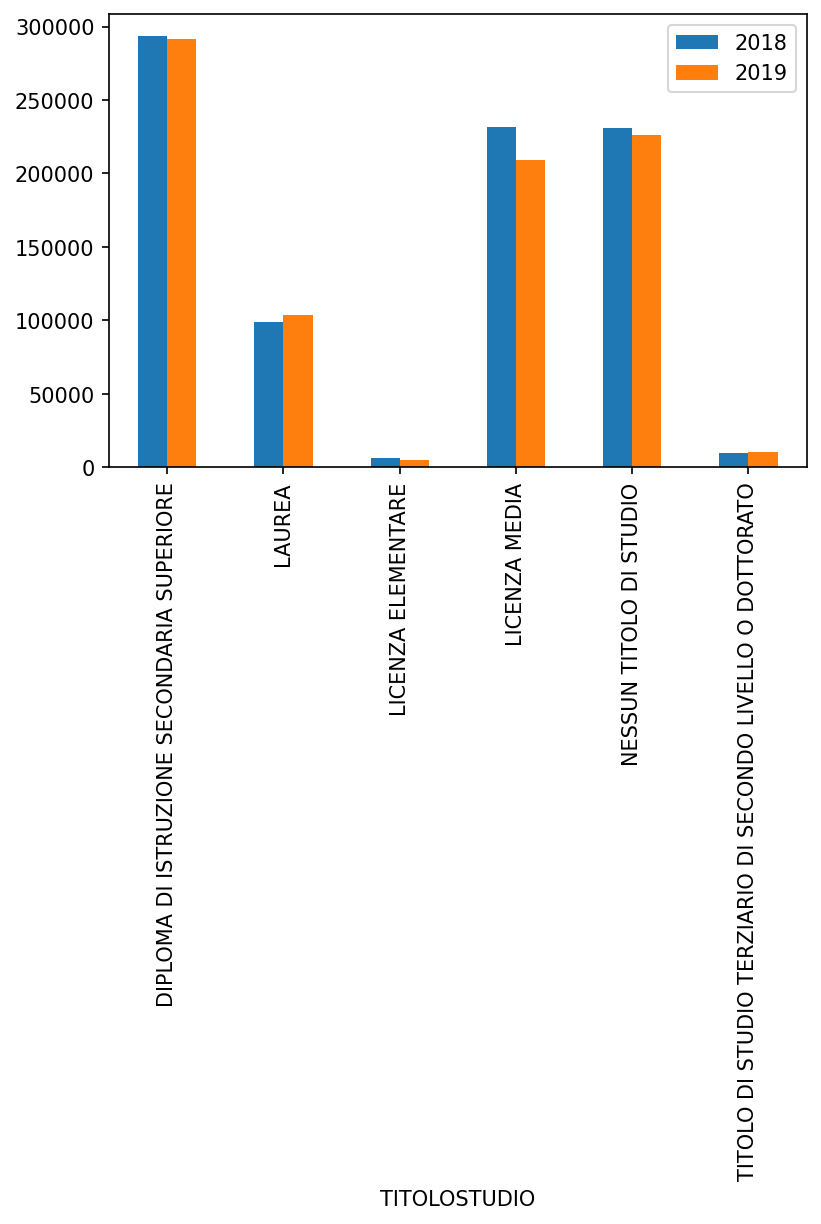

In [59]:
istruction_df = rap_lavoro_attivati[['DATA', 'TITOLOSTUDIO', "CONTRATTO"]]
istruction_df = istruction_df[(istruction_df['TITOLOSTUDIO'].isin(titoli))]
group_ist = istruction_df.groupby(['TITOLOSTUDIO', 'DATA']).count()
group_ist['CONTRATTO']

group_ist.unstack().plot(kind='bar', stacked=False)
plt.legend([2018,2019])
plt.xticks(rotation=90)
plt.show()

In [60]:
len(rap_lavoro_attivati)

1716132

In [61]:
test = group_ist
test['TITOLOSTUDIO'] = test.index.get_level_values(0)
test.head()

CONTRATTO  \
TITOLOSTUDIO                               DATA              
DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE 2018     293617   
                                           2019     291309   
LAUREA                                     2018      98577   
                                           2019     103979   
LICENZA ELEMENTARE                         2018       6096   

                                                                               TITOLOSTUDIO  
TITOLOSTUDIO                               DATA                                              
DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE 2018  DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  
                                           2019  DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  
LAUREA                                     2018                                      LAUREA  
                                           2019                                      LAUREA  
LICENZA ELEMENTARE                         2018                          LICENZA ELEMENTARE

In [62]:
test_ist = grado_istruzione_age[grado_istruzione_age['EDU_ATTAIN'].isin(titoli)]
test['OBS_VALUE'] = test_ist.groupby(['EDU_ATTAIN', 'TIME_PERIOD']).sum()['OBS_VALUE']

In [63]:
test.loc[:, 'CONTRATTO'] = test['CONTRATTO']/test['OBS_VALUE']

In the following plot, we will see the percentage of all the education levels of the started contracts over the total population with the same education level.

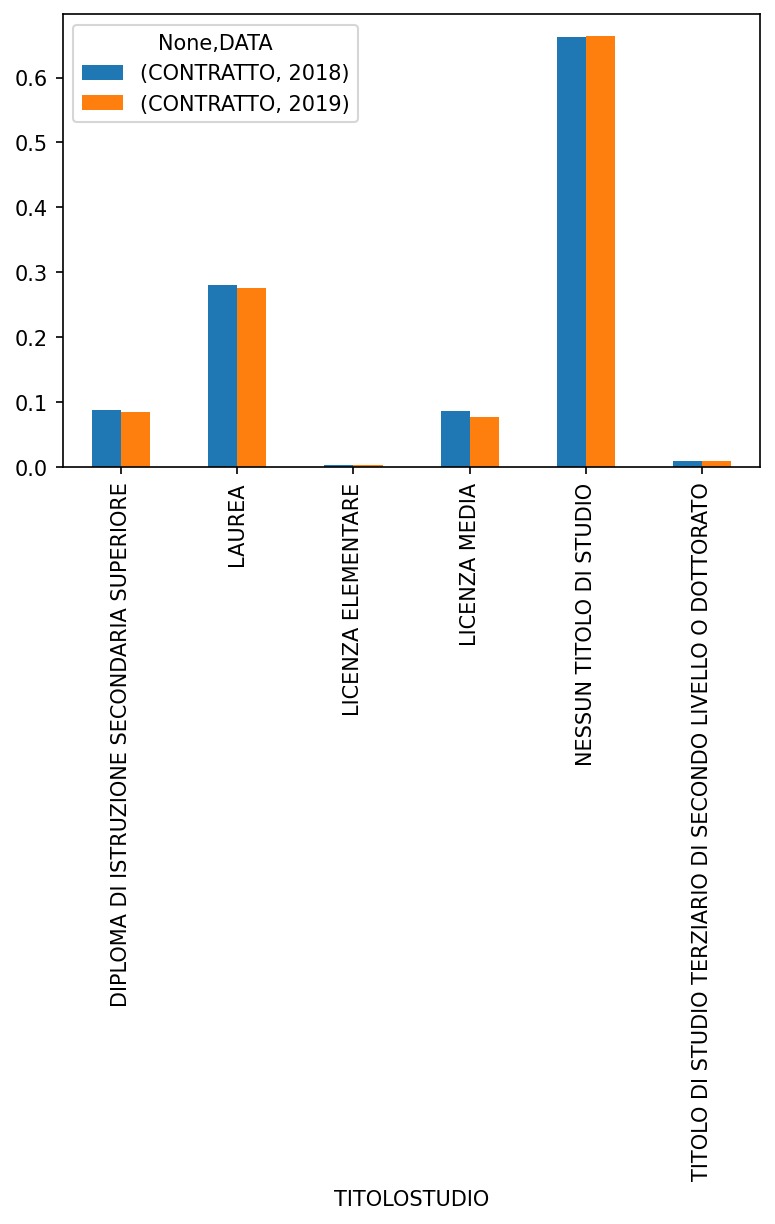

In [64]:
test = test[['CONTRATTO', 'TITOLOSTUDIO']]
test.unstack().plot(kind='bar', stacked=False)
plt.xticks(rotation=90)
plt.show()

Surprisingly, people without a qualification are the most hired in comparison with their total number. We can further analyze the dataset and in particular the values about people that doesn't have a qualification. 

First, let's see which are their most frequent type of contracts.

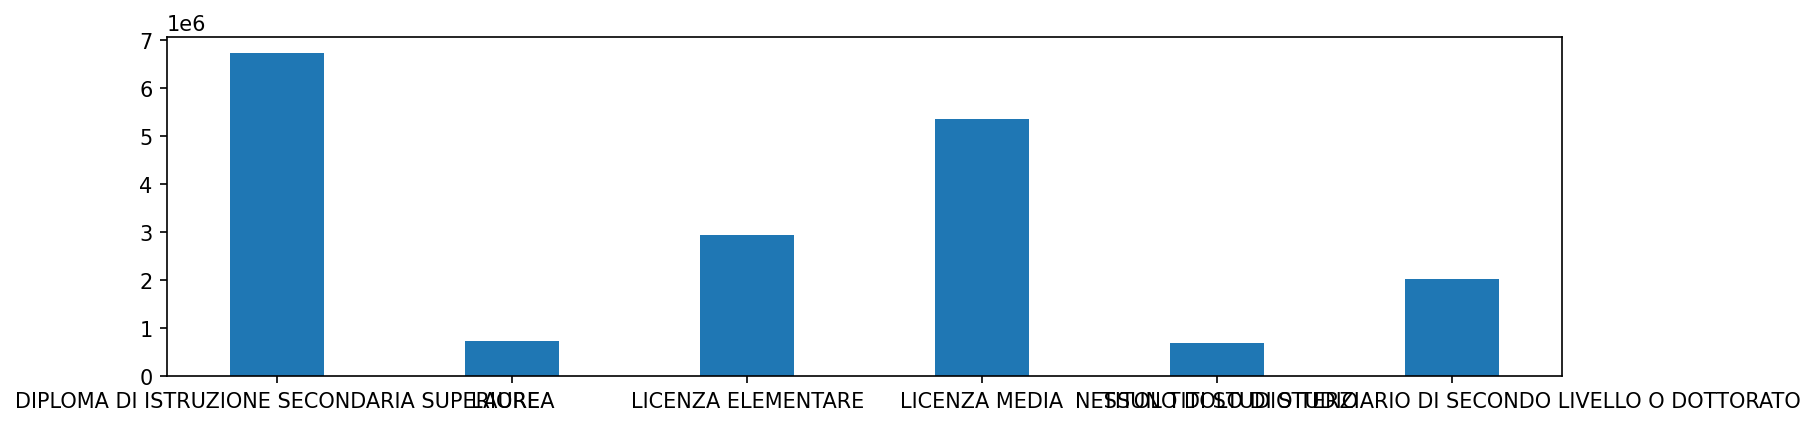

In [65]:
#TODO delete
df = grado_istruzione_age.copy()
df = df.groupby(['EDU_ATTAIN']).sum()
plt.figure(figsize=(12, 3))
plt.bar(df.index, df["OBS_VALUE"], width=0.4)
plt.show()


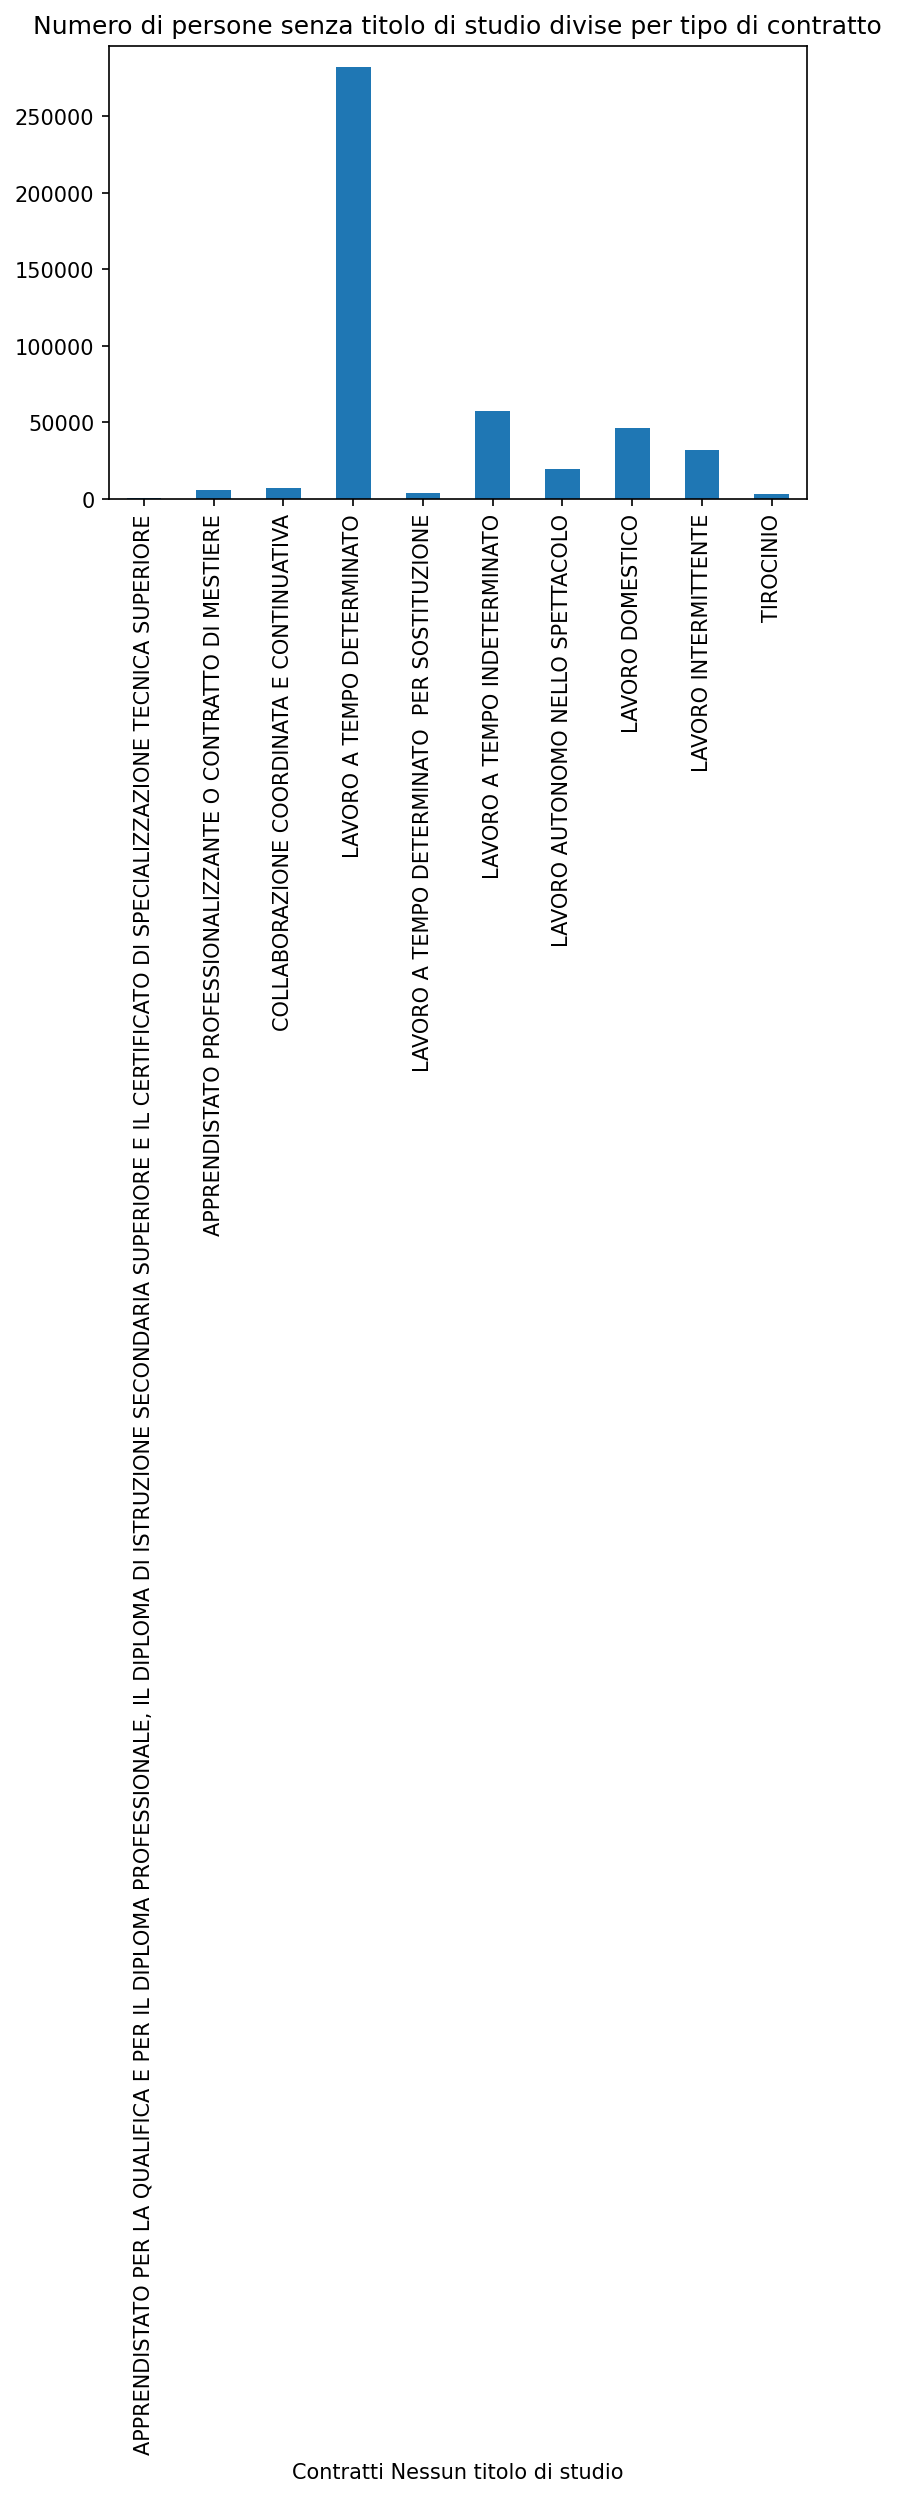

In [66]:
df = rap_lavoro_attivati[['CONTRATTO', 'TITOLOSTUDIO']]
df = df[df['TITOLOSTUDIO'] == 'NESSUN TITOLO DI STUDIO']
df = df.groupby(['CONTRATTO']).count()
df.plot(kind='bar', legend=False)
plt.xlabel('Contratti Nessun titolo di studio')
plt.title('Numero di persone senza titolo di studio divise per tipo di contratto')
plt.show()

In [67]:
#delete this cell
df

,TITOLOSTUDIO
CONTRATTO,
APPRENDISTATO PER LA QUALIFICA E PER IL DIPLOM...,162
APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,5348
COLLABORAZIONE COORDINATA E CONTINUATIVA,6912
LAVORO A TEMPO DETERMINATO,282130
LAVORO A TEMPO DETERMINATO PER SOSTITUZIONE,3947
LAVORO A TEMPO INDETERMINATO,57559
LAVORO AUTONOMO NELLO SPETTACOLO,19611
LAVORO DOMESTICO,45963
LAVORO INTERMITTENTE,31887


So the vast majority of the contracts are fixed-term contracts, this could mean that probably many start more than one contract per year and so happens more often that multiple contracts belong to the same person. 

We can also try to understand at which age people without an educational qualification are hired compared to others.

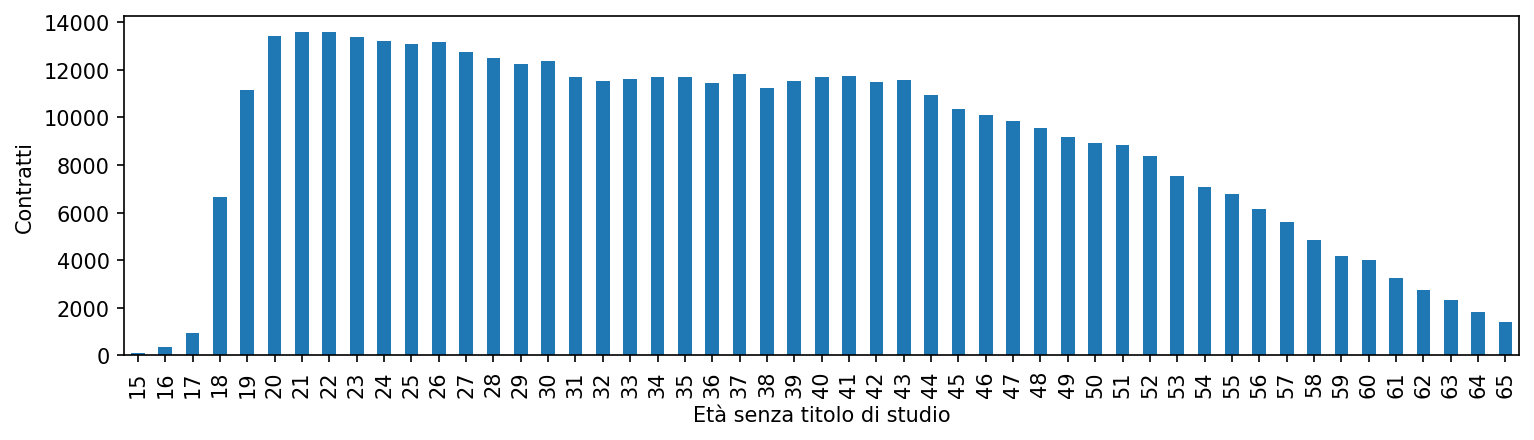

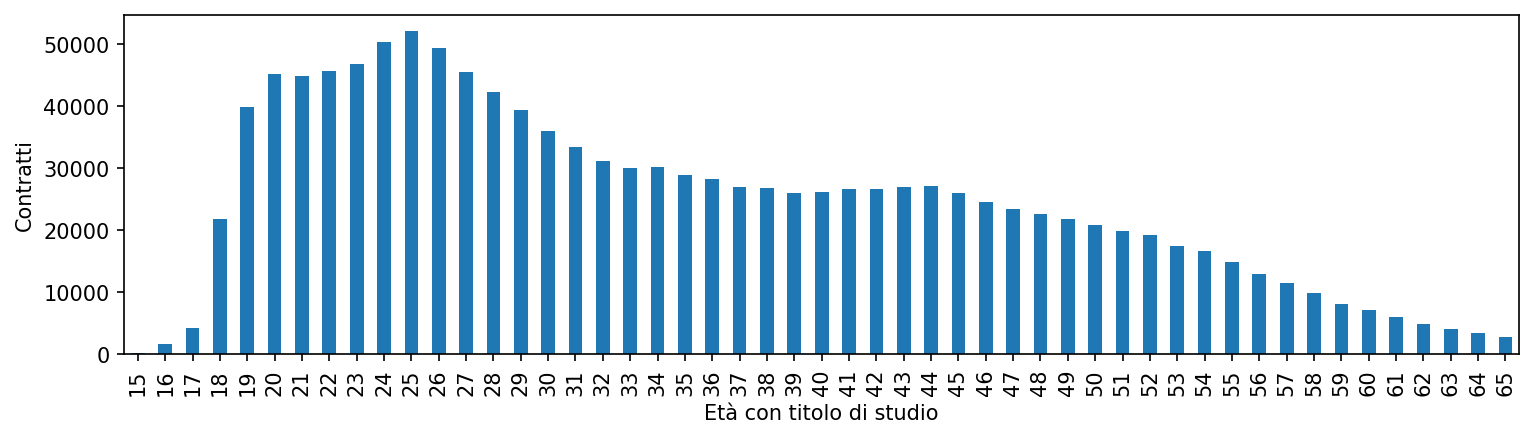

In [68]:
df = rap_lavoro_attivati[['CONTRATTO', 'ETA', 'TITOLOSTUDIO']]
df = df[df['TITOLOSTUDIO'] == 'NESSUN TITOLO DI STUDIO']
df = df[['ETA', 'CONTRATTO']]
df = df.groupby(['ETA']).count()

df.plot(kind='bar', legend=False, stacked=False, figsize=(12,3))
plt.ylabel('Contratti')
plt.xlabel('Età senza titolo di studio')
plt.show()
###########################################################################
df = rap_lavoro_attivati[['CONTRATTO', 'ETA', 'TITOLOSTUDIO']]
df = df[df['TITOLOSTUDIO'] != 'NESSUN TITOLO DI STUDIO']
df = df[['ETA', 'CONTRATTO']]
df = df.groupby(['ETA']).count()

df.plot(kind='bar', legend=False, stacked=False, figsize=(12,3))
plt.ylabel('Contratti')
plt.xlabel('Età con titolo di studio')
plt.show()

Can be noted that the plot of people *with* a qualification have a maximum at age 25 then it quickly decrease until 30 and at that point it starts decreasing more slowly. Instead, the plot of people *without* a qualification is  a lot different. It keeps really high until 43 and then it starts slowly decreasing. This means that people without schooling are hired in a much wider range, and this means a lot more people.

Now we can plot the number of people hired with an open-ended contract divided per age and educational qualification to stress once again the importance of this two features.

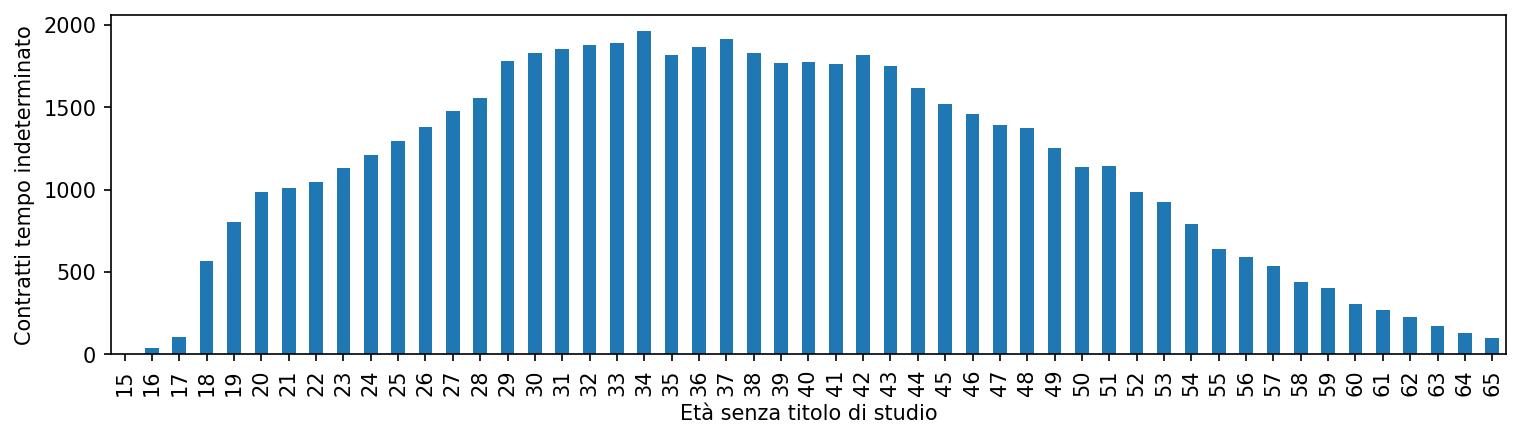

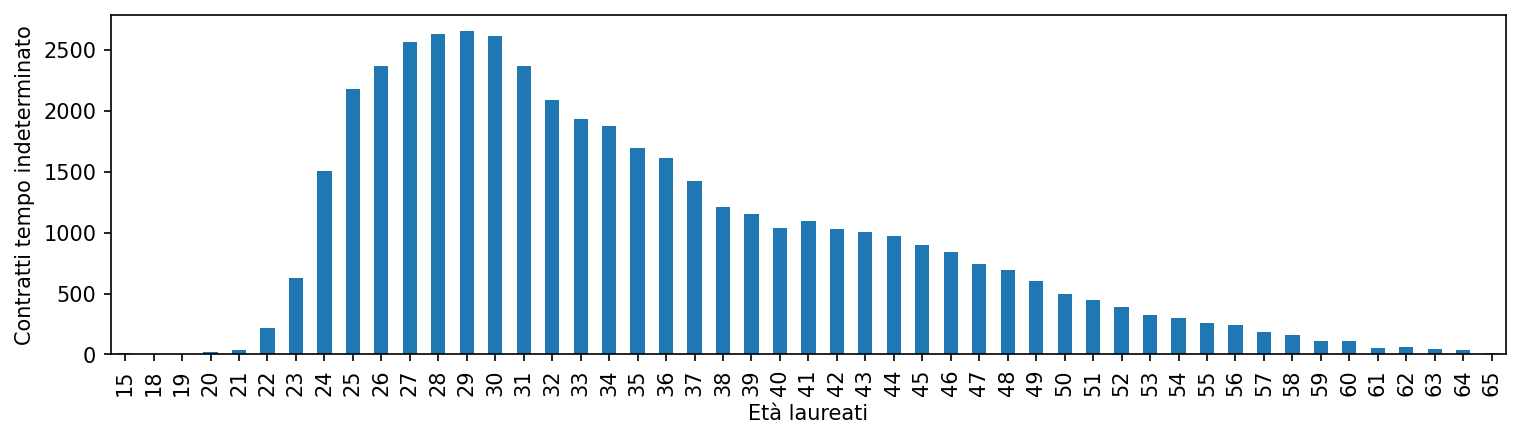

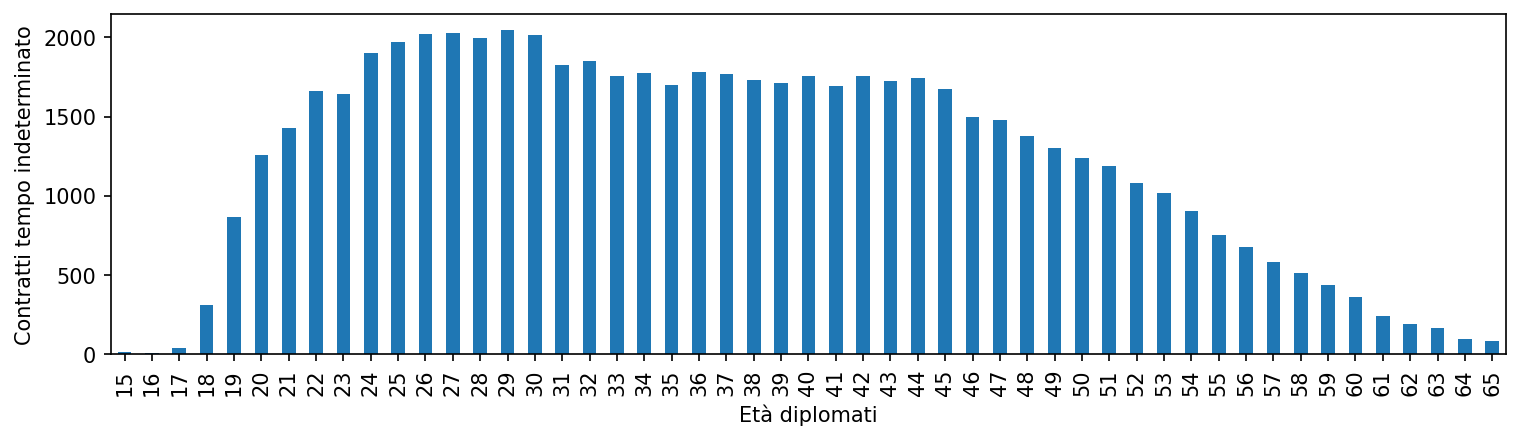

In [69]:
df = rap_lavoro_attivati[['CONTRATTO', 'ETA', 'TITOLOSTUDIO']]
df = df[df['TITOLOSTUDIO'] == 'NESSUN TITOLO DI STUDIO']
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO'][['ETA', 'CONTRATTO']]
df = df.groupby(['ETA']).count()

df.plot(kind='bar', legend=False, stacked=False, figsize=(12,3))
plt.ylabel('Contratti tempo indeterminato')
plt.xlabel('Età senza titolo di studio')
plt.show()
###########################################################################
df = rap_lavoro_attivati[['CONTRATTO', 'ETA', 'TITOLOSTUDIO']]
df = df[df['TITOLOSTUDIO'] == 'LAUREA']
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO'][['ETA', 'CONTRATTO']]
df = df.groupby(['ETA']).count()

df.plot(kind='bar', legend=False, stacked=False, figsize=(12,3))
plt.ylabel('Contratti tempo indeterminato')
plt.xlabel('Età laureati')
plt.show()
###########################################################################
df = rap_lavoro_attivati[['CONTRATTO', 'ETA', 'TITOLOSTUDIO']]
df = df[df['TITOLOSTUDIO'] == 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE']
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO'][['ETA', 'CONTRATTO']]
df = df.groupby(['ETA']).count()

df.plot(kind='bar', legend=False, stacked=False, figsize=(12,3))
plt.ylabel('Contratti tempo indeterminato')
plt.xlabel('Età diplomati')
plt.show()

In general we can say that lower is the schooling level, higher is the possibility to get an open-ended contract *after* you are 30 years old. While higher the educational qualification is, higher is the chance to obtain an open-ended contract *before* 30 years old.

In [70]:
grado_istruzione_age[(grado_istruzione_age['EDU_ATTAIN'] == 'NESSUN TITOLO DI STUDIO') & (grado_istruzione_age['TIME_PERIOD'] == 2018)]['OBS_VALUE'].sum()

348277

In [71]:
rap_lavoro_attivati[(rap_lavoro_attivati['TITOLOSTUDIO'] == 'NESSUN TITOLO DI STUDIO') & (rap_lavoro_attivati['DATA'] == 2018)].count()

DATA                         230693
GENERE                       230693
ETA                          230693
SETTOREECONOMICODETTAGLIO    230693
TITOLOSTUDIO                 230693
CONTRATTO                    230693
MODALITALAVORO               230693
PROVINCIAIMPRESA             230693
ITALIANO                     230693
agerange                     230693
dtype: int64

In [72]:
grado_istruzione_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
504396,MONZA E BRIANZA,F,Y_GE65,LAUREA,2018,610
504397,MONZA E BRIANZA,F,Y_GE65,LAUREA,2019,543
504399,MONZA E BRIANZA,F,Y_GE65,LICENZA MEDIA,2018,24744
504400,MONZA E BRIANZA,F,Y_GE65,LICENZA MEDIA,2019,25871
504402,MONZA E BRIANZA,F,Y_GE65,TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO ...,2018,3595


In the next section we'll see a graph comparing the number of contract activated and the tota number of population in 2018

/tmp/ipykernel_216714/47337985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activate2018.loc[:,'agerange'] = pd.cut(activate2018['ETA'], bins, labels = labels,include_lowest = True)
/tmp/ipykernel_216714/47337985.py:17: RuntimeWarning: divide by zero encountered in log
  newContract = np.log(testAge.values)


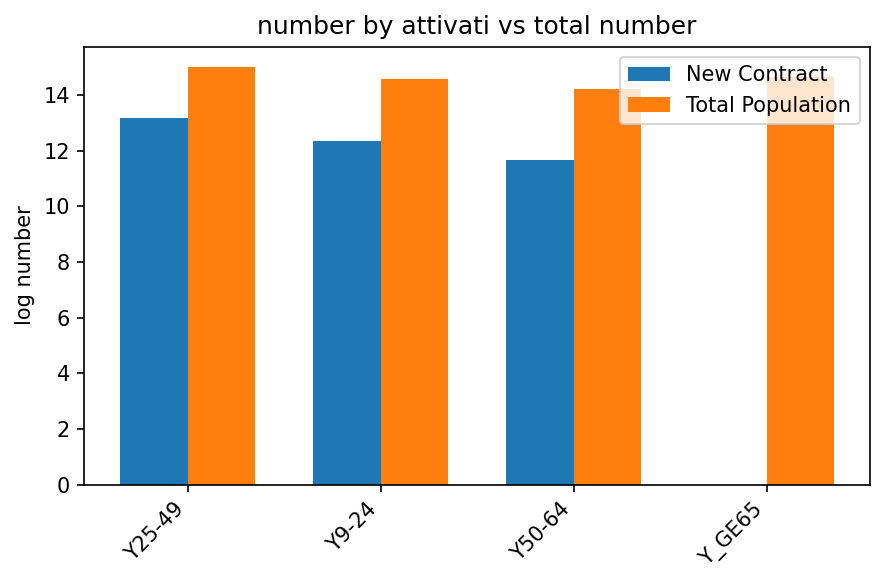

In [73]:
import datetime as dt

activate2018 = rap_lavoro_attivati[rap_lavoro_attivati['DATA'] == 2018]
bins = [0,25, 50, 65, 200]
labels = ['Y9-24', 'Y25-49', 'Y50-64','Y_GE65' ]
activate2018.loc[:,'agerange'] = pd.cut(activate2018['ETA'], bins, labels = labels,include_lowest = True)



istr2018 = grado_istruzione_age[(grado_istruzione_age['TIME_PERIOD']== 2018)]
total = istr2018.groupby(['AGE_NOCLASS']).sum()


testAge = activate2018['agerange'].value_counts()

labels = testAge.index
newContract = np.log(testAge.values)
totalPopulation = np.log(total['OBS_VALUE'].values)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, newContract, width, label='New Contract')
rects2 = ax.bar(x + width/2, totalPopulation, width, label='Total Population')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('log number')
ax.set_title('number by attivati vs total number')
ax.set_xticks(x)
ax.set_xticklabels(labels=labels,rotation=45,
    horizontalalignment='right');
ax.legend()



fig.tight_layout()

plt.show()

In the next plots we will see the relevance of the age (exclusively) on the type of contract.  

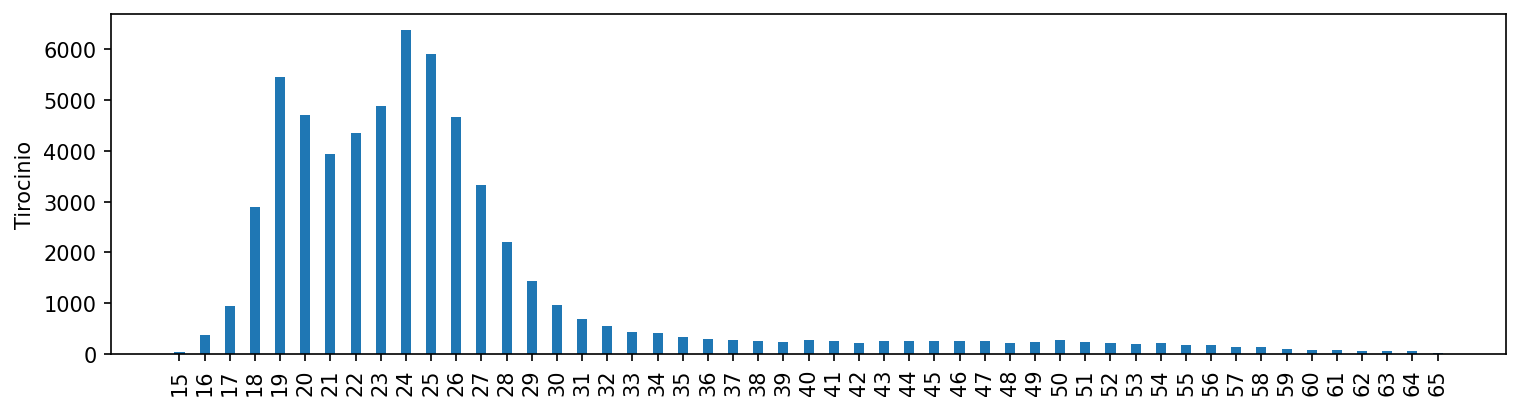

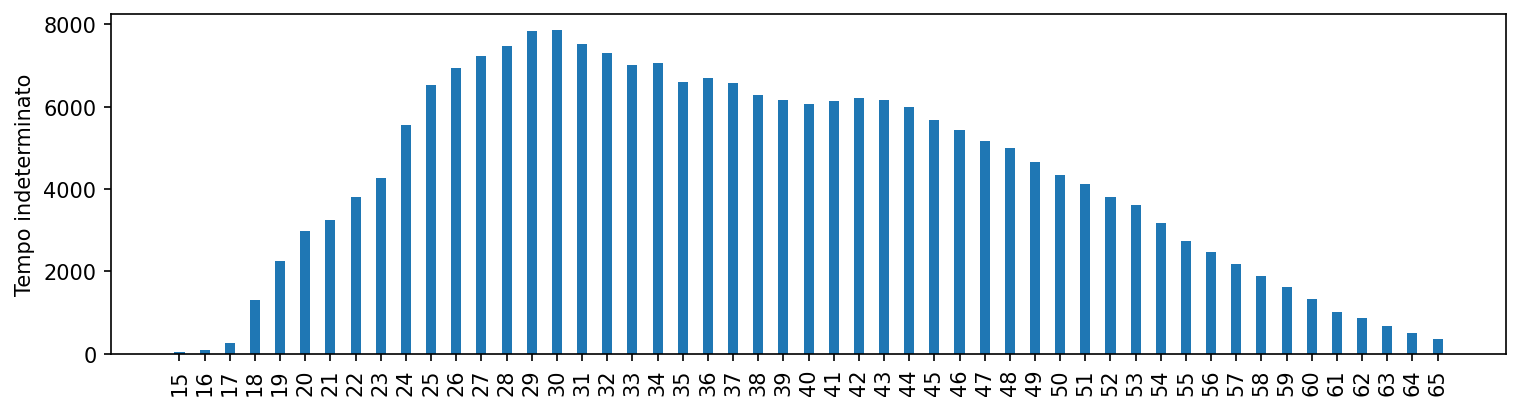

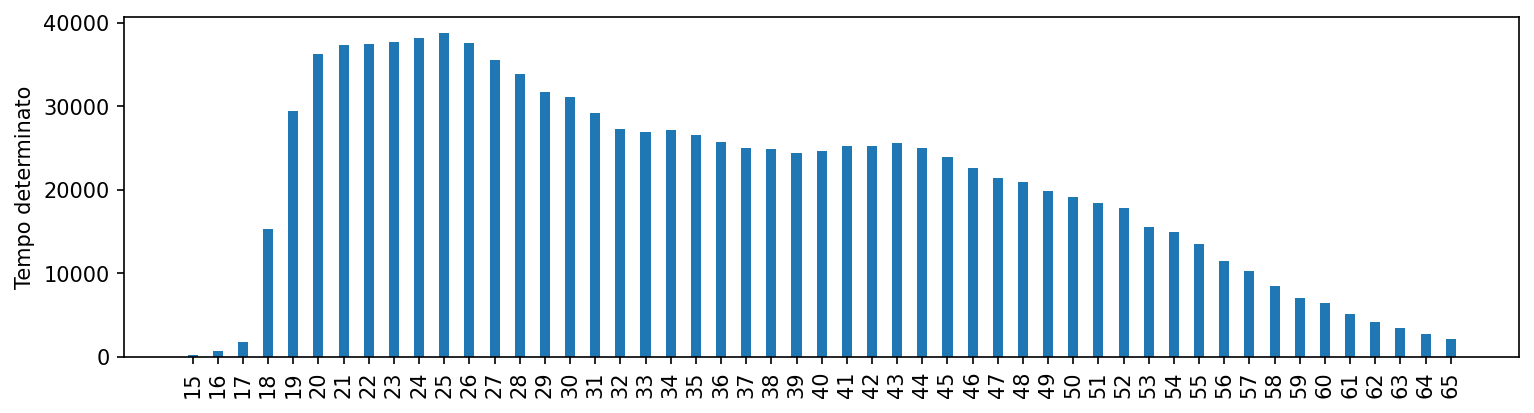

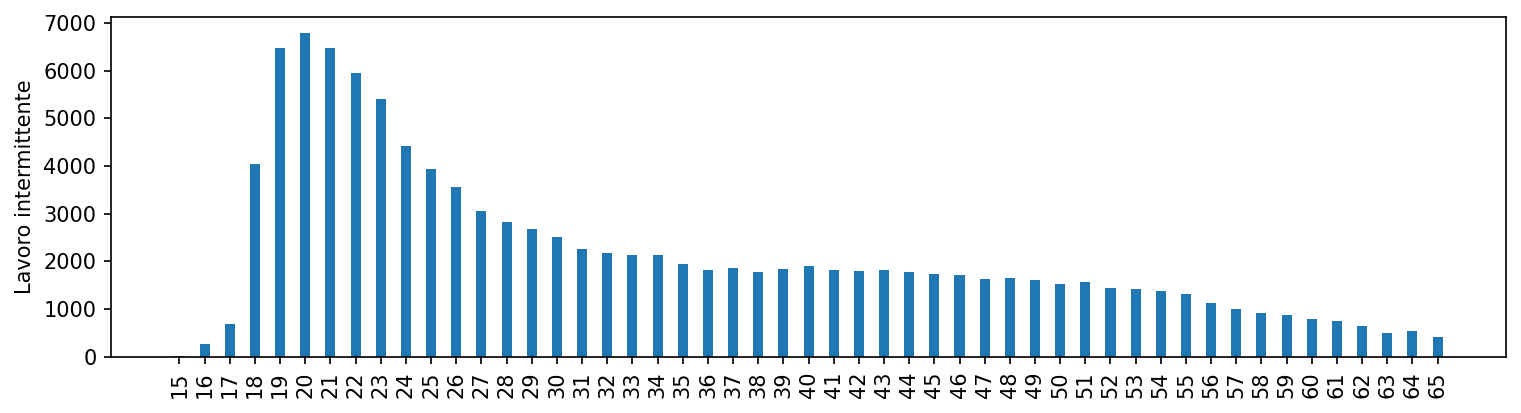

In [74]:
df = rap_lavoro_attivati[['ETA', 'CONTRATTO']]
df = df[df['CONTRATTO'] == 'TIROCINIO']
df = df.groupby(['ETA']).count()
plt.figure(figsize=(12, 3))
plt.xticks(ticks=range(15,66), rotation=90)
plt.ylabel('Tirocinio')
plt.bar(df.index, df["CONTRATTO"], width=0.4)
plt.show()
###########################
df = rap_lavoro_attivati[['ETA', 'CONTRATTO']]
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO']
df = df.groupby(['ETA']).count()
plt.figure(figsize=(12, 3))
plt.xticks(ticks=range(15,66), rotation=90)
plt.ylabel('Tempo indeterminato')
plt.bar(df.index, df["CONTRATTO"], width=0.4)
plt.show()
###########################
df = rap_lavoro_attivati[['ETA', 'CONTRATTO']]
df = df[df['CONTRATTO'] == 'LAVORO A TEMPO DETERMINATO']
df = df.groupby(['ETA']).count()
plt.figure(figsize=(12, 3))
plt.xticks(ticks=range(15,66), rotation=90)
plt.ylabel('Tempo determinato')
plt.bar(df.index, df["CONTRATTO"], width=0.4)
plt.show()

###########################
df = rap_lavoro_attivati[['ETA', 'CONTRATTO']]
df = df[df['CONTRATTO'] == 'LAVORO INTERMITTENTE']
df = df.groupby(['ETA']).count()
plt.figure(figsize=(12, 3))
plt.xticks(ticks=range(15,66), rotation=90)
plt.ylabel('Lavoro intermittente')
plt.bar(df.index, df["CONTRATTO"], width=0.4)
plt.show()

As expected, better job contracts are gained around 30s. Interestingly, internship has two peaks at 19 and 24, that are the ages at which, usually, people finish, respectively, high school and university.

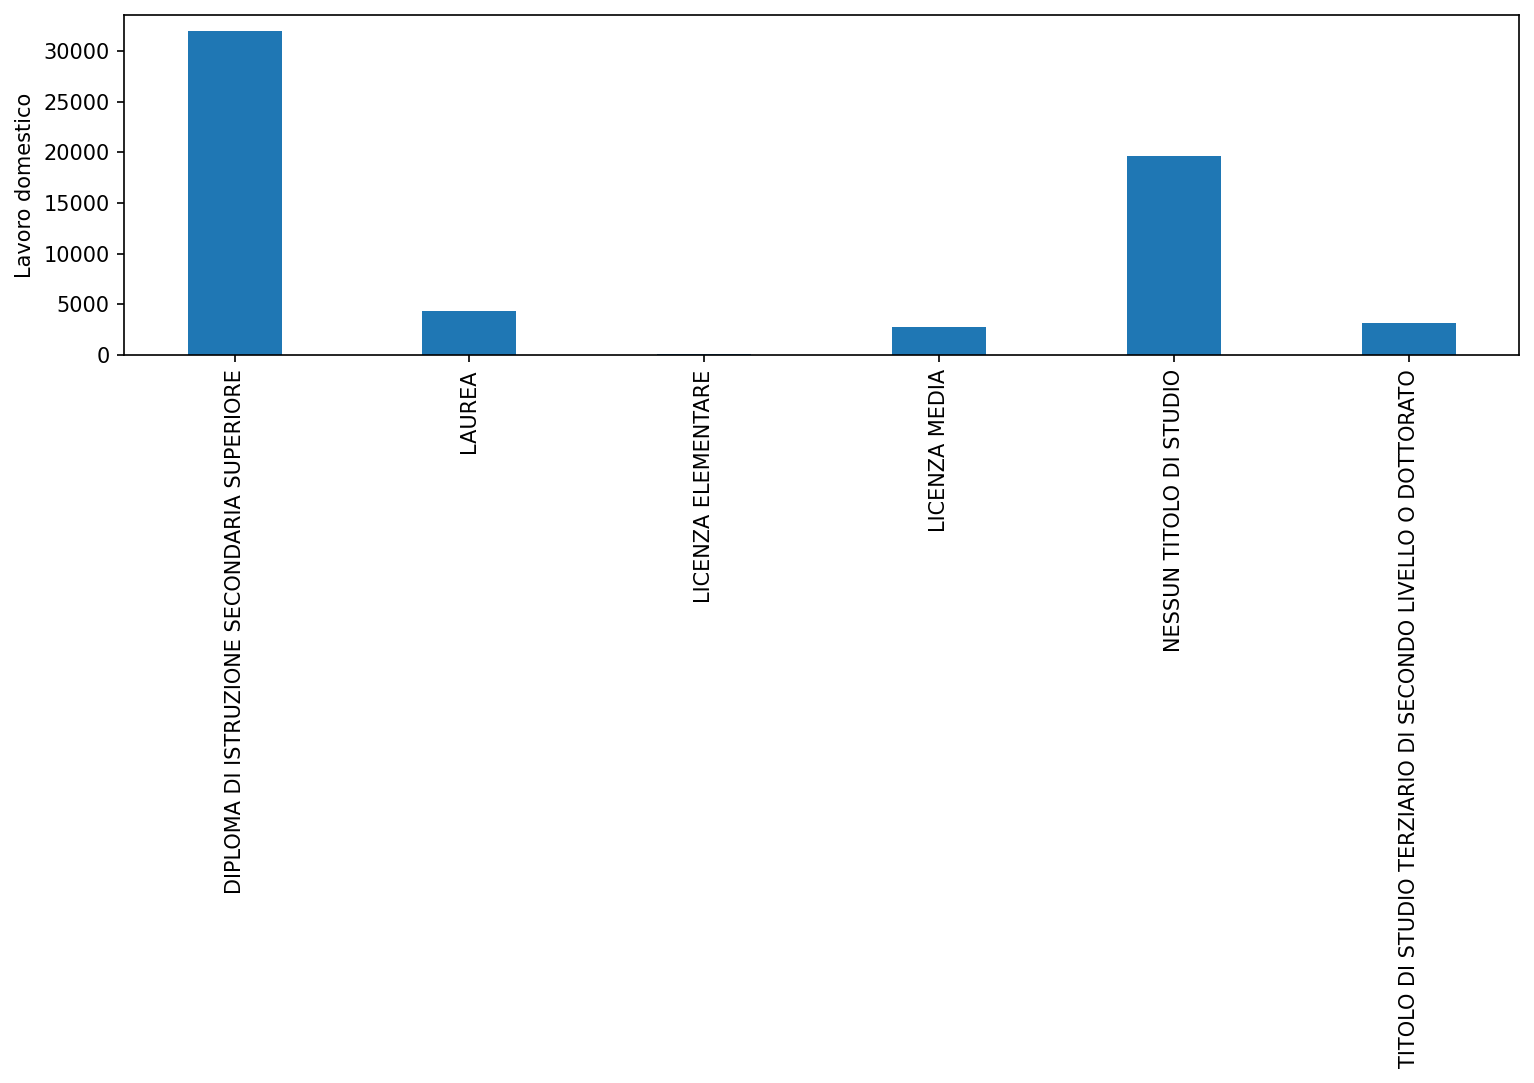

In [75]:
#TODO valuta se tenere o eliminare
df = rap_lavoro_attivati[['TITOLOSTUDIO', 'CONTRATTO']]
df = df[df['CONTRATTO'] == 'LAVORO AUTONOMO NELLO SPETTACOLO']
df = df.groupby(['TITOLOSTUDIO']).count()
plt.figure(figsize=(12, 3))
plt.xticks(rotation=90)
plt.ylabel('Lavoro domestico')
plt.bar(df.index, df["CONTRATTO"], width=0.4)
plt.show()

In [76]:
set(rap_lavoro_attivati['CONTRATTO'])

{'APPRENDISTATO PER LA QUALIFICA E PER IL DIPLOMA PROFESSIONALE, IL DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE E IL CERTIFICATO DI SPECIALIZZAZIONE TECNICA SUPERIORE',
 'APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO DI MESTIERE',
 'COLLABORAZIONE COORDINATA E CONTINUATIVA',
 'LAVORO A TEMPO DETERMINATO',
 'LAVORO A TEMPO DETERMINATO  PER SOSTITUZIONE',
 'LAVORO A TEMPO INDETERMINATO',
 'LAVORO AUTONOMO NELLO SPETTACOLO',
 'LAVORO DOMESTICO',
 'LAVORO INTERMITTENTE',
 'TIROCINIO'}

In [77]:
grado_istruzione_age[grado_istruzione_age.REF_AREA == 'Milano'].groupby(['REF_AREA', 'TIME_PERIOD', 'GENDER', 'EDU_ATTAIN', 'AGE_NOCLASS']).sum().head()

OBS_VALUE
REF_AREA TIME_PERIOD GENDER EDU_ATTAIN                                 AGE_NOCLASS           
Milano   2018        F      DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE Y25-49          233709
                                                                       Y50-64          168626
                                                                       Y9-24            63168
                                                                       Y_GE65          104197
                            LAUREA                                     Y25-49           51061

In [78]:
series_to_set('REF_AREA', grado_istruzione_age)

{'Bergamo',
 'Brescia',
 'Como',
 'Cremona',
 'Lecco',
 'Lodi',
 'MONZA E BRIANZA',
 'Mantova',
 'Milano',
 'Pavia',
 'Sondrio',
 'Varese'}

In [79]:
condizione_professionale_age = pd.read_csv(PurePath('dataset', 'Condizione professionale per età - Lombardia.csv'),low_memory=False)
condizione_professionale_age.head()

,DATAFLOW,FREQ,REF_AREA,INDICATOR,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE,OBS_STATUS,NOTE_DS,NOTE_REF_AREA,NOTE_INDICATOR,NOTE_GENDER,NOTE_AGE_NOCLASS,NOTE_CITIZENSHIP,NOTE_EDU_ATTAIN,NOTE_CUR_ACT_STAT,NOTE_LOC_DEST,NOTE_REAS_COMMUTING
0,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,1,2018,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN
1,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,1,2019,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN
2,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,12,2018,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN
3,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,12,2019,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN
4,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,22,2018,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN


In [80]:
condizione_professionale_age = condizione_professionale_age[['REF_AREA', 'GENDER', 'AGE_NOCLASS', 'CUR_ACT_STAT', 'TIME_PERIOD', 'OBS_VALUE']]
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
0,012001,F,Y_GE15,1,2018,42
1,012001,F,Y_GE15,1,2019,37
2,012001,F,Y_GE15,12,2018,7
3,012001,F,Y_GE15,12,2019,8
4,012001,F,Y_GE15,22,2018,49


In [81]:
condizione_professionale_age = condizione_professionale_age[condizione_professionale_age.REF_AREA.isin(area_codes)]

condizione_professionale_age.loc[:, 'REF_AREA'] = condizione_professionale_age['REF_AREA'].apply(lambda x: get_provincia_by_code(x)) 
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
388442,MONZA E BRIANZA,F,Y_GE15,1,2018,167236
388443,MONZA E BRIANZA,F,Y_GE15,1,2019,170506
388444,MONZA E BRIANZA,F,Y_GE15,12,2018,20274
388445,MONZA E BRIANZA,F,Y_GE15,12,2019,20119
388446,MONZA E BRIANZA,F,Y_GE15,22,2018,187510


Regarding the meaning of the values in `CUR_ACT_STAT`:
- $22$: labor force;
 - $1$ : employed;
 - $12$: unemployed;
- $23$: non-labor force.

Thus, for our analysis, we can keep the labor force only. 

In [82]:
condizione_professionale_age = condizione_professionale_age[condizione_professionale_age['CUR_ACT_STAT'] == 22]
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
388446,MONZA E BRIANZA,F,Y_GE15,22,2018,187510
388447,MONZA E BRIANZA,F,Y_GE15,22,2019,190625
388464,MONZA E BRIANZA,F,Y_GE65,22,2018,3750
388465,MONZA E BRIANZA,F,Y_GE65,22,2019,4229
388482,MONZA E BRIANZA,F,Y15-24,22,2018,10108


For now, we can consider only the overall number and not the age range.

In [83]:
condizione_professionale_age = condizione_professionale_age[condizione_professionale_age['AGE_NOCLASS'] == 'Y_GE15']
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
388446,MONZA E BRIANZA,F,Y_GE15,22,2018,187510
388447,MONZA E BRIANZA,F,Y_GE15,22,2019,190625
388538,MONZA E BRIANZA,M,Y_GE15,22,2018,234355
388539,MONZA E BRIANZA,M,Y_GE15,22,2019,235901
388629,MONZA E BRIANZA,T,Y_GE15,22,2018,421865


array([<AxesSubplot:ylabel='(OBS_VALUE, 2018)'>,
       <AxesSubplot:ylabel='(OBS_VALUE, 2019)'>], dtype=object)

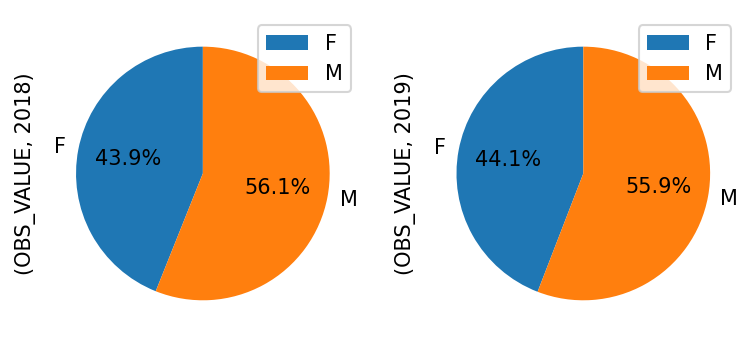

In [84]:
df = condizione_professionale_age[['GENDER', 'TIME_PERIOD', 'OBS_VALUE']].copy()
df = df[df['GENDER'] != 'T']
df = df.groupby(['GENDER', 'TIME_PERIOD']).sum()
df.unstack().plot(kind='pie', subplots=True, autopct='%1.1f%%', startangle=90)

The same holds for the `GENDER`, we can consider the total number of people that could potentially work.

In [85]:
condizione_professionale_age = condizione_professionale_age[condizione_professionale_age['GENDER'] == 'T']
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
388629,MONZA E BRIANZA,T,Y_GE15,22,2018,421865
388630,MONZA E BRIANZA,T,Y_GE15,22,2019,426526
389181,Varese,T,Y_GE15,22,2018,411189
389182,Varese,T,Y_GE15,22,2019,411106
389457,Como,T,Y_GE15,22,2018,277484


In [86]:
set(condizione_professionale_age['REF_AREA'])

{'Bergamo',
 'Brescia',
 'Como',
 'Cremona',
 'Lecco',
 'Lodi',
 'MONZA E BRIANZA',
 'Mantova',
 'Milano',
 'Pavia',
 'Sondrio',
 'Varese'}

In [87]:
set(rap_lavoro_attivati['PROVINCIAIMPRESA'])

{'BERGAMO',
 'BRESCIA',
 'COMO',
 'CREMONA',
 'LECCO',
 'LODI',
 'MANTOVA',
 'MILANO',
 'MONZA E BRIANZA',
 'PAVIA',
 'SONDRIO',
 'VARESE'}

<a id='ml_model'></a>
# Building a machine learning model
In this section we will see three different machine learning algorithm and decide which is the best for our goal.
Before creating the traing and test set we must encode the data before feeding it to the algorithm, to do this we will use two approach: the first approach is a simple encoding so for every distinct value of a feature will be assigned a number, the second approach try to assign to each different value of a feature a numeric value with some meaning when possible.

In [88]:
import matplotlib as mtl
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<a id='feature_encoding'></a>
## Feature encoding

The first step is to create a new dataset in which we will apply all the needed changes. Here we will add new columns for every encoding we perform, so in the end this dataset will contain the original value plus the encoded one, this choice has been made to recognize the original value from its encoding.

In [89]:
model_dt= rap_lavoro_attivati[['DATA', 'GENERE', 'ETA', 'agerange', 'TITOLOSTUDIO', 'CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','SETTOREECONOMICODETTAGLIO']].copy(deep=True)

<a id='simp_encoding'></a>
### Simple encoding
In this case we simply assign a numeric value to each unique value. We convert all field to float except `CONTRATTO` that i converted to int and its values start from zero, this is done to avoid using deprecated method.

In [90]:
model_dt['RANKGENERE'] = model_dt['GENERE'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKTITOLOSTUDIO'] = model_dt['TITOLOSTUDIO'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKMODALITALAVORO'] = model_dt['MODALITALAVORO'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKPROVINCIAIMPRESA'] = model_dt['PROVINCIAIMPRESA'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKagerange'] = model_dt['agerange'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKSETTOREECONOMICODETTAGLIO'] = model_dt['SETTOREECONOMICODETTAGLIO'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKCONTRATTO'] = model_dt['CONTRATTO'].rank(method='dense', ascending=False).astype('int')
model_dt['RANKCONTRATTO'] = model_dt['RANKCONTRATTO'].sub(1)

<a id='elab_encoding'></a>
### Elaborate encoding
 For this encoding we will assign to the field `RANKPROVINCIAIMPRESA` the number of people that live in that area, for the field `RANKTITOLOSTUDIO` the minimum age necessary to acquire that title and for the fields `RANKSETTOREECONOMICODETTAGLIO` and `RANKMODALITALAVORO` we will substitute a value with its occurences.

#### Province column

For obtainig the number of people we will use the dataset `Grado_istruzione_per_età_Lombardia`, from this dataset we will extrapolate the population for every lombary province during 2019, create a map and apply it to `model_dt`.

In [91]:
model_dt.index = range(0,len(model_dt))
grado_istruzione_age.loc[:, 'REF_AREA'] = grado_istruzione_age['REF_AREA'].str.upper() 
to_zip = grado_istruzione_age[['REF_AREA', 'TIME_PERIOD', 'OBS_VALUE']].groupby(['REF_AREA', 'TIME_PERIOD']).sum().copy()
province_map = to_zip.to_dict().get('OBS_VALUE')
model_dt['MyENPROVINCIAIMPRESA'] = pd.Series(model_dt[['PROVINCIAIMPRESA','DATA']].itertuples(index=False, name=None)).map(province_map)

#### Study title column
Here we manually create a dictionary that assign to a study title its minimum age, then apply it to the dataset

In [92]:
rank_edu_map = {
    'NESSUN TITOLO DI STUDIO':0,
    'LICENZA ELEMENTARE':11,
    'LICENZA MEDIA':14,
    'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE':19,
    'LAUREA':22,
    'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO':24    
}


In [93]:
model_dt['MyENTITOLOSTUDIO'] = mapping(model_dt['TITOLOSTUDIO'], rank_edu_map)

####  Economic sector and work modality columns
For these two columns we simply count the ocurrence and substittue them to the correct value

In [94]:
model_dt['MyENMODALITALAVORO'] = mapping(model_dt['MODALITALAVORO'], dict(model_dt['MODALITALAVORO'].value_counts()))
model_dt['MyENSETTOREECONOMICODETTAGLIO'] =  mapping(model_dt['SETTOREECONOMICODETTAGLIO'], dict(model_dt['SETTOREECONOMICODETTAGLIO'].value_counts()))

The remaining columns will use the previous encoding because age group and gender do not need to preserve information.

<a id='models_trainig'></a>
# Training the models
In this section we divide our data into training and testing data through the specific function and take a first look at the model performances.This work will be repeated for the two different encoding.

In [95]:
X = model_dt[['RANKGENERE', 'RANKTITOLOSTUDIO', 'RANKagerange', 'RANKPROVINCIAIMPRESA','RANKSETTOREECONOMICODETTAGLIO', 'RANKMODALITALAVORO']]
y = model_dt['RANKCONTRATTO']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

## Simple encoding

### Multi layer perceptron

In [96]:
mlpSimpModel = MLPClassifier(random_state=1, max_iter=20, hidden_layer_sizes=(24,24), early_stopping = True)
mlpSimpModel = mlpSimpModel.fit(X_train, y_train)

#prediction and probability
mlpSimpPred = mlpSimpModel.predict(X_test)
mlp_proba = mlpSimpModel.predict_proba(X_test)

#Report metrix
simpReportMLP = classification_report(y_test, mlpSimpPred,output_dict= True, zero_division=0)
accMlp = accuracy_score(y_test, mlpSimpPred)
print('Accuracy:')
print(accMlp)

/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450:

Accuracy:
0.741938265821044


### Random forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

simpForest = RandomForestClassifier(n_estimators=24, max_depth=6, random_state=0,max_features = None,n_jobs = -1)
simpForest.fit(X_train, y_train)
    
forestSimpPred = simpForest.predict(X_test)
reportSimpForest = classification_report(y_test, forestSimpPred,output_dict= True)

score = simpForest.score(X_test, y_test)

print("Score: ", round(score*100, 3))

/home/achille/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/achille/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/achille/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score:  73.524


### XGboost

In [98]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import xgboost as xgb

xgSimp = xgb.XGBClassifier(learning_rate = 0.3,
                max_depth =4, alpha = 2, n_estimators = 35, eval_metric='mlogloss',use_label_encoder=False)
#Fit the model
xgSimp.fit(X_train,y_train)
#xg_reg.save_model("categorical-model.json")

#Make predictions
xgSimpPred = xgSimp.predict(X_test)
xgSimpReport = classification_report(y_test, xgSimpPred,output_dict= True)

In [99]:
accuracy_score(y_test, xgSimpPred)

0.744707283588908

## Elaborate encoding

In [100]:
X = model_dt[['RANKGENERE', 'MyENTITOLOSTUDIO', 'ETA', 'MyENPROVINCIAIMPRESA','MyENSETTOREECONOMICODETTAGLIO', 'MyENMODALITALAVORO']]
y = model_dt['RANKCONTRATTO']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

### Multi Layer Perceptron

In [101]:
mlpModel = MLPClassifier(random_state=1, max_iter=20, hidden_layer_sizes=(24,24), early_stopping = True)
mlpModel = mlpModel.fit(X_train, y_train)

#prediction and probability
mlp_pred = mlpModel.predict(X_test)
mlp_proba = mlpModel.predict_proba(X_test)

#Report metrix
reportMLP = classification_report(y_test, mlp_pred,output_dict= True, zero_division=0)
accMlp = accuracy_score(y_test, mlp_pred)
print('Accuracy:')
print(accMlp)

/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/achille/.local/lib/python3.10/site-packages/sklearn/base.py:450:

Accuracy:
0.6334734157978524


### Random Forest


In [102]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=15, max_depth=5, random_state=0,max_features = None,n_jobs = -1)
model.fit(X_train, y_train)
# TODO: score your model on your test set

forestPred = model.predict(X_test)
reportForest = classification_report(y_test, forestPred,output_dict= True, zero_division=0)
score = model.score(X_test, y_test)

In [103]:
print('Accuracy:')
print(score)

Accuracy:
0.7220376987317992


### XGboost

In [104]:
import xgboost as xgb
xg_class = xgb.XGBClassifier(learning_rate = 0.3,
                max_depth =4, alpha = 2, n_estimators = 35, eval_metric='mlogloss',use_label_encoder =False)
#Fit the model
xg_class.fit(X_train,y_train)
#xg_reg.save_model("categorical-model.json")

#Make predictions
preds = xg_class.predict(X_test)

xbreport = classification_report(y_test, preds,output_dict= True)

In [105]:
print('Accuracy:')
print(accuracy_score(y_test, preds))

Accuracy:
0.7473434444436675


## Model Evaluation

### Accuracy Comparison

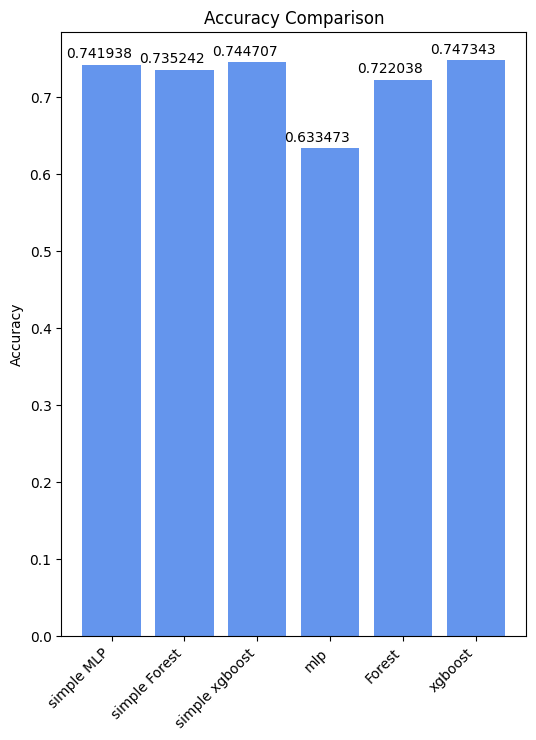

In [106]:
modelsAccuracy =[simpReportMLP['accuracy'],
reportSimpForest['accuracy'],
xgSimpReport['accuracy'],
reportMLP['accuracy'],
reportForest['accuracy'],
xbreport['accuracy']]

modelName = ['simple MLP', 'simple Forest', 'simple xgboost', 'mlp', 'Forest', 'xgboost']


x = np.arange(len(modelName))
width = 0.35

accuracyGraph, axis = plt.subplots()
accuracyGraph.dpi = 100
accuracyGraph.set_figheight(8)
bars = axis.bar(x - width/2, modelsAccuracy, width)

axis.bar_label(bars, padding=3)

#Precison red an white wine graph
axis.bar(modelName,modelsAccuracy, label ='Accuracy', color= 'cornflowerblue')
axis.legend(loc = 'upper left')
axis.set_title("Accuracy Comparison")
axis.set_xticks(x)
axis.set_xticklabels(labels=modelName,rotation=45,horizontalalignment='right');
axis.set( ylabel='Accuracy')
axis.get_legend().remove()

plt.show()

As is possible to see from the graph the accuracy is almost the same with the exeption of the multi layer perceptron with the custom encoding, this could be caused by the fact that for these type of models is easier to work with small data or the other encoding create false relation assigning the same value for different feature.

### Precision Comparison
Because the accuracy alone is not enough to evaluate a model, we now see the precision that is the correctly classified sample divided by the sum of true and false positive. Considering these to metric together is possible to better analyze the performace of the different models.

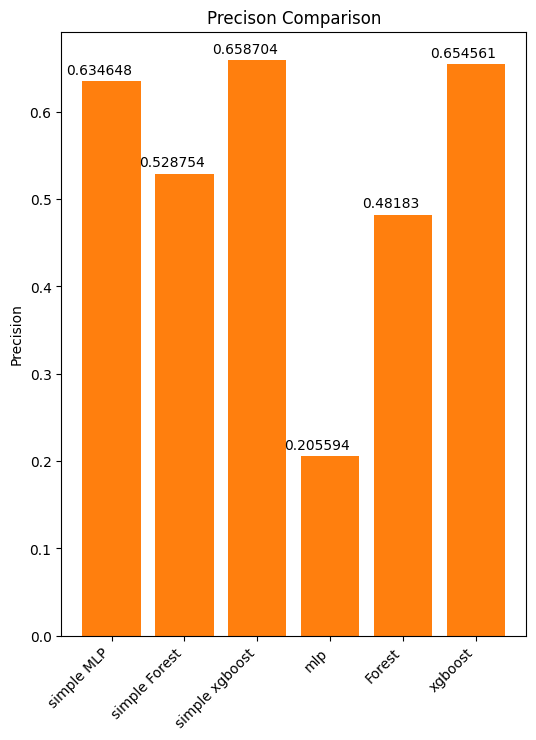

In [107]:
modelsPrecision =[simpReportMLP['macro avg']['precision'],
reportSimpForest['macro avg']['precision'],
xgSimpReport['macro avg']['precision'],
reportMLP['macro avg']['precision'],
reportForest['macro avg']['precision'],
xbreport['macro avg']['precision']]

x = np.arange(len(modelName))
width = 0.35

precisonGraph, axis = plt.subplots()
precisonGraph.dpi = 100
precisonGraph.set_figheight(8)
rects1 = axis.bar(x - width/2, modelsPrecision, width)

axis.bar_label(rects1, padding=3)

#Precison red an white wine graph
axis.bar(modelName,modelsPrecision, label='Precison')
axis.legend(loc = 'upper left')
axis.get_legend().remove()
axis.set_title("Precison Comparison")
axis.set_xticks(x)
axis.set_xticklabels(labels=modelName,rotation=45,horizontalalignment='right');
axis.set( ylabel='Precision')
plt.show()

From this comparison is clear that XGboost have the better performance and that there are some problem with multi layer perceptron with custom encoding, wwhile the models that use random forest have similar performance.
As said previously there is the possibility that the low varince of value in the simple encoding cause the multi layer perceptron to make wrong assumption on the relation between feature bringing to better result when compared to the model that uses our encoding.

Because the difference between the two models that uses XGboost is minimal, for bulding an example of application we will use the one with the custom encoding.

<a id='model_usage'></a>
## Possible application
In the following part is shown how the tained model can be used to predict a type of contract when given all the necessary information.
Here we feed the data directly in the code, but in more realistic scenario hte model could be implemented in the backend of a site and a user from the front end could choose the parameter through, for example, a drop downm list; doing so would simplify the choice for the user and prevent spelling error.

In [108]:
contrattoMap=dict(zip(model_dt.RANKCONTRATTO, model_dt.CONTRATTO))
modlavoroMap=dict(zip(model_dt.MODALITALAVORO, model_dt.MyENMODALITALAVORO))
settoreEcoMap=dict(zip(model_dt.SETTOREECONOMICODETTAGLIO, model_dt.MyENSETTOREECONOMICODETTAGLIO))
provinciaMap=dict(zip(model_dt.PROVINCIAIMPRESA, model_dt.MyENPROVINCIAIMPRESA))
agerangeMap=dict(zip(model_dt.agerange, model_dt.RANKagerange))
titoloStudioMap=dict(zip(model_dt.TITOLOSTUDIO, model_dt.MyENTITOLOSTUDIO))
genereMap=dict(zip(model_dt.GENERE, model_dt.RANKGENERE))

In [109]:
def findContract(genere, studyTitle,age,provincia,settoreEco,modLavoro):
    myJob = { 
    'RANKGENERE': [genereMap[genere]],
    'MyENTITOLOSTUDIO': [titoloStudioMap[studyTitle]],
    'ETA':[age],
    'MyENPROVINCIAIMPRESA':[provinciaMap[provincia]],
    'MyENSETTOREECONOMICODETTAGLIO':[settoreEcoMap[settoreEco]],
    'MyENMODALITALAVORO':[modlavoroMap[modLavoro]]};
    contract = contrattoMap[xg_class.predict(pd.DataFrame(myJob))[0]]
    return contract

### Testing the method

In [119]:
findContract('M','DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE', 18, 'BERGAMO', 'I', 'TEMPO PIENO')

'LAVORO A TEMPO INDETERMINATO'

# Conclusion
In this project we have seen how data is imported analyzed and clened. Then we created a question based on the data that we had, and tried to answer that question building a machine learnig model.

Because of the categorical nature of the data used, we needed to encode it before feeding it to the machine learning algorithm, so we implemented two different encoding to see if a simple encoding will perform better than a custom encoding in which we tried to give meaningful value to the feature.

After trainig, testing and evaluating differnt algorithm we discover that the simple encodig performs better than the custom one in most cases but is possible that create false connection between feature.

In the end we implement an exaple of application that use the model trained for answering the previously created question.